## Phân tích xu hướng sở thích âm nhạc

#### Import các thư viện và các package cần thiết

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from matplotlib.figure import Figure 
from wordcloud import WordCloud

#### Load dữ liệu

In [2]:
df_normal  = pd.read_csv('list_info_03.csv') # Load các thông tin các video về âm nhạc thường
# df = pd.read_csv('list_info_trending.csv') # Load thông tin các video về âm nhạc trending
df_normal.head()


,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,caption,privacyStatus,embeddable,madeForKids,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,topicCategories
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac remix', 'nhạc remix', 'nhạc remix nghe ...",10,vi,PT57M27S,2d,...,False,public,True,False,15496668,102261.0,NaN,0,5372.0,['https://en.wikipedia.org/wiki/Electronic_mus...
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu mot nguoi dung', 'như một người dưng', '...",10,NaN,PT1H9M43S,2d,...,False,public,True,False,2257,11.0,NaN,0,11.0,"['https://en.wikipedia.org/wiki/Music', 'https..."
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,False,public,True,False,2672142,79841.0,NaN,0,8832.0,['https://en.wikipedia.org/wiki/Hip_hop_music'...
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,NaN,10,vi,PT7M30S,2d,...,False,public,True,False,15190,642.0,NaN,0,93.0,['https://en.wikipedia.org/wiki/Music']
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài lâm', 'bảng xếp hạng vpop', 'liên khúc ...",10,vi,PT2H13M13S,2d,...,True,public,True,False,255169,745.0,NaN,0,12.0,"['https://en.wikipedia.org/wiki/Music', 'https..."


In [3]:
# Xem thông tin tổng quan về data frame
df_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4962 non-null   object 
 1   publishAt             4962 non-null   object 
 2   title                 4962 non-null   object 
 3   description           4783 non-null   object 
 4   channelTitle          4962 non-null   object 
 5   tags                  4322 non-null   object 
 6   categoryId            4962 non-null   int64  
 7   defaultAudioLanguage  2776 non-null   object 
 8   duration              4962 non-null   object 
 9   dimension             4962 non-null   object 
 10  definition            4962 non-null   object 
 11  caption               4962 non-null   bool   
 12  privacyStatus         4962 non-null   object 
 13  embeddable            4962 non-null   bool   
 14  madeForKids           4962 non-null   bool   
 15  viewCount            

In [4]:
# Lọc ra các video âm nhạc tức categoryId là 10 - Music
df_normal = df_normal[df_normal['categoryId']==10]

In [5]:
# Xử lý các giá trị null trong data frame
df_normal_preprocessed = df_normal.fillna({'description':'', 'tags':'', 'defaultAudioLanguage':'', 'likeCount':0, 'dislikeCount':0, 'commentCount':0, 'topicCategories':'' })
df_normal_preprocessed.head()

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,caption,privacyStatus,embeddable,madeForKids,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,topicCategories
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac remix', 'nhạc remix', 'nhạc remix nghe ...",10,vi,PT57M27S,2d,...,False,public,True,False,15496668,102261.0,0.0,0,5372.0,['https://en.wikipedia.org/wiki/Electronic_mus...
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu mot nguoi dung', 'như một người dưng', '...",10,,PT1H9M43S,2d,...,False,public,True,False,2257,11.0,0.0,0,11.0,"['https://en.wikipedia.org/wiki/Music', 'https..."
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,False,public,True,False,2672142,79841.0,0.0,0,8832.0,['https://en.wikipedia.org/wiki/Hip_hop_music'...
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,,10,vi,PT7M30S,2d,...,False,public,True,False,15190,642.0,0.0,0,93.0,['https://en.wikipedia.org/wiki/Music']
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài lâm', 'bảng xếp hạng vpop', 'liên khúc ...",10,vi,PT2H13M13S,2d,...,True,public,True,False,255169,745.0,0.0,0,12.0,"['https://en.wikipedia.org/wiki/Music', 'https..."


In [6]:
# Mô tả các thuộc tính có giá trị nguyên
df_normal.describe()

,categoryId,viewCount,likeCount,dislikeCount,favoriteCount,commentCount
count,3250.0,3.250000e+03,2.742000e+03,0.0,3250.0,3.212000e+03
mean,10.0,7.757448e+06,1.767001e+05,NaN,0.0,1.735291e+04
std,0.0,4.465801e+07,8.834424e+05,NaN,0.0,2.045653e+05
min,10.0,0.000000e+00,0.000000e+00,NaN,0.0,0.000000e+00
25%,10.0,7.630100e+04,1.056250e+03,NaN,0.0,2.100000e+01
50%,10.0,3.032205e+05,4.079500e+03,NaN,0.0,9.400000e+01
75%,10.0,1.666436e+06,3.117650e+04,NaN,0.0,6.162500e+02
max,10.0,1.201917e+09,2.083092e+07,NaN,0.0,8.776885e+06


In [7]:
# Vẽ biểu đồ tròn thống kê theo số view của các video
def pieCharViewCounts(df):
    listVideo_10KView = df[df['viewCount']<100000]['id']
    listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
    listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
    listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
    listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']

    y = np.array([len(listVideo_10KView),
                    len(listVideo_100KView),
                    len(listVideo_1MView),
                    len(listVideo_10MView),
                    len(listVideo_100MView),
                ])
    mylabel = ['Video chuc nghin view', 'Video tram nghin view', 'Video trieu view', 'Video chuc trieu view', 'Video tram trieu view']
   
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.pie(y, labels=mylabel)
    plt.show()

C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']


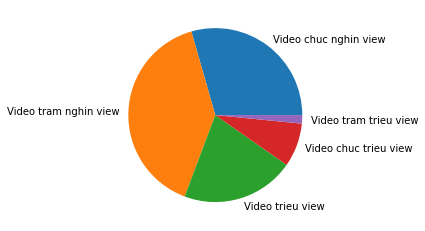

In [10]:
pieCharViewCounts(df_normal)

#### Xử lý tag và tên channel (thêm "_" vào các tag)


In [8]:
df_normal_preprocessed['tags'].fillna('', inplace=True)

In [9]:
def removeSpace(listItems, noise):
    tagsPreprocessed = []
    for item in listItems:
        if item == noise:
            tagsPreprocessed.append(item)
            continue
        item = item.replace(' ','_')
        item = item.replace(',_',', ')
        tagsPreprocessed.append(item)
    # print(tagsPreprocessed)
    return tagsPreprocessed

In [10]:
print(df_normal_preprocessed['tags'])
tagsPreprocessed = removeSpace(df_normal_preprocessed['tags'], ' ')
# df_normal_preprocessed.drop(columns=['tags'])
# df_normal_preprocessed.assign(tags = tagsPreprocessed)
# print(df_normal_preprocessed['tags'])
# print(tagsPreprocessed)
df_normal_preprocessed['tags'] = tagsPreprocessed

0       ['nhac remix', 'nhạc remix', 'nhạc remix nghe ...
1       ['nhu mot nguoi dung', 'như một người dưng', '...
2       ['DraTelling', 'Dra Telling', 'dratelling', 'd...
3                                                        
4       ['hoài lâm', 'bảng xếp hạng vpop', 'liên khúc ...
                              ...                        
4956    ['Michael Bublé', 'Michael Buble', 'WBR', 'War...
4957    ['Nation Boss', 'Yaksta', 'Emotions', 'Trouble...
4958    ['Violette Wautier', 'V Violette', 'The Voice ...
4959    ['เพลงลูกทุ่ง', 'แกรมมี่ โกลด์', 'grammy gold'...
4960    ['J balvin', 'jbalvin new song', 'sech', 'una ...
Name: tags, Length: 3250, dtype: object


#### Xử lý topic categories

In [11]:
df_normal_preprocessed['topicCategories'] = df_normal['topicCategories'].fillna('')

In [12]:
listTopics=[]
for index, row in df_normal_preprocessed.iterrows():
    listTopic = row['topicCategories']
    if listTopic == '':
        listTopics.append(listTopic)
        continue
    topicStr = ''
    listTopic = listTopic.replace('https://en.wikipedia.org/wiki/','')
    listTopic = listTopic.replace("'Music'",'')
    listTopic = listTopic.replace(',','')
    listTopic = listTopic.replace('[','')
    listTopic = listTopic.replace(']','')
    listTopic = listTopic.replace('\'','')
    print(listTopic)
    listTopics.append(listTopic)
    #     #topic = topic.removesuffix("https://en.wikipedia.org/wiki/")
    #     print(topic)

print(type(listTopics))

Electronic_music Hip_hop_music  Pop_music
 Rhythm_and_blues Soul_music
Hip_hop_music 

 Pop_music
 Music_of_Asia

Hip_hop_music 
 Music_of_Asia Pop_music
Hip_hop_music 
 Music_of_Asia




Entertainment

 Music_of_Asia Pop_music
Knowledge

Knowledge

Knowledge
 Music_of_Asia Pop_music
Knowledge




Knowledge


 Music_of_Asia Pop_music
Entertainment Television_program



Electronic_music 
Entertainment Music_of_Asia Television_program

 Music_of_Asia Pop_music
 Pop_music
 Pop_music
Entertainment Music_of_Asia Television_program
Entertainment Television_program
 Music_of_Asia Pop_music
 Music_of_Asia
 Pop_music

 Music_of_Asia
Christian_music 

Hip_hop_music 

Christian_music 
Electronic_music 

 Music_of_Asia



 Pop_music

 Music_of_Asia
 Pop_music
Hip_hop_music  Music_of_Asia Pop_music
 Music_of_Asia
Entertainment Television_program
 Pop_music

 Music_of_Asia
 Pop_music


Electronic_music 




 Pop_music




 Music_of_Asia
Entertainment
 Pop_music

 Music_of_Asia Pop_music

 Music_of_A

In [13]:
df_normal_preprocessed['topicCategories'] = listTopics
df_normal_preprocessed

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,caption,privacyStatus,embeddable,madeForKids,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,topicCategories
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac_remix', 'nhạc_remix', 'nhạc_remix_nghe_...",10,vi,PT57M27S,2d,...,False,public,True,False,15496668,102261.0,0.0,0,5372.0,Electronic_music Hip_hop_music Pop_music
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu_mot_nguoi_dung', 'như_một_người_dưng', '...",10,,PT1H9M43S,2d,...,False,public,True,False,2257,11.0,0.0,0,11.0,Rhythm_and_blues Soul_music
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra_Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,False,public,True,False,2672142,79841.0,0.0,0,8832.0,Hip_hop_music
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,,10,vi,PT7M30S,2d,...,False,public,True,False,15190,642.0,0.0,0,93.0,
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài_lâm', 'bảng_xếp_hạng_vpop', 'liên_khúc_...",10,vi,PT2H13M13S,2d,...,True,public,True,False,255169,745.0,0.0,0,12.0,Pop_music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4956,Mk6ZzzWWJ1A,2021-10-15T13:00:20Z,Michael Bublé - Let It Snow! [10th Anniversary...,"The Official Music Video for Michael Bublé's ""...",Michael Bublé,"['Michael_Bublé', 'Michael_Buble', 'WBR', 'War...",10,,PT2M53S,2d,...,False,public,True,False,4724387,42123.0,0.0,0,965.0,Christian_music
4957,ekzPebnuEls,2021-06-08T16:15:12Z,Nation Boss & Yaksta - Emotions (Official Musi...,Nation Boss & Yaksta - Emotions (prod by Troub...,Nation Boss Official,"['Nation_Boss', 'Yaksta', 'Emotions', 'Trouble...",10,en,PT3M29S,2d,...,False,public,True,False,2438926,68810.0,0.0,0,4001.0,Hip_hop_music Reggae
4958,5AJOOGuGn5U,2021-05-24T12:00:15Z,Violette Wautier - กักตัว (Official Music Video),Violette Wautier - กักตัว (Official Music Vide...,Violette Wautier,"['Violette_Wautier', 'V_Violette', 'The_Voice_...",10,en,PT4M2S,2d,...,True,public,True,False,5229516,87646.0,0.0,0,2776.0,Pop_music
4959,tnkPPRhfRvE,2021-11-04T06:00:25Z,ไม่เคย(เพลงประกอบภาพยนตร์ ส้มป่อย) - ไม้เมือง ...,เพลง : ไม่เคย(เพลงประกอบภาพยนตร์ ส้มป่อย)\nศิล...,GRAMMY GOLD OFFICIAL,"['เพลงลูกทุ่ง', 'แกรมมี่_โกลด์', 'grammy_gold'...",10,th,PT3M2S,2d,...,False,public,True,False,1351117,19096.0,0.0,0,609.0,Music_of_Asia


#### Xử lý thời gian 

In [14]:
def convertHour(str):
    if str.find('H') == -1:
        return 0
    hour = str.split('T')[1].split('H')[0]
    return hour

def convertMinute(str):
    if str.find('M') == -1:
        return 0
    if str.find('H') != -1:
        minute = str.split('H')[1].split('M')[0]
    else:
        minute = str.split('T')[1].split('M')[0]
    return minute

def convertSecond(str):
    if str.find('S') == -1:
        return 0
    if str.find('M') == -1:
        if str.find('H') == -1:
            second = str.split('T')[1].split('S')[0]
        else:    
            second = str.split('H')[1].split('S')[0]
    else:
        second = str.split('M')[1].split('S')[0]
    return second

In [15]:
hours, minutes, seconds = [], [], []
years, months, days = [], [], []
durationInt = []
for index, row in df_normal.iterrows():
    hours.append(int(convertHour(row['duration'])))
    minutes.append(int(convertMinute(row['duration'])))
    seconds.append(int(convertSecond(row['duration'])))
    years.append(int(row['publishAt'].split('-',1)[0]))
    months.append(int(row['publishAt'].split('-',1)[1].split('-',1)[0]))
    days.append(int(row['publishAt'].split('-',2)[2].split('T')[0]))
    durationInt.append(hours[-1]*60*60+minutes[-1]*60+seconds[-1])

In [16]:
df_normal_preprocessed = df_normal_preprocessed.assign(hourDuration=hours, minuteDuration=minutes, secondDuration=seconds, yearPublished=years, monthPublished=months, dayPublished=days, durationInt = durationInt)
df_normal_preprocessed.head()

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,favoriteCount,commentCount,topicCategories,hourDuration,minuteDuration,secondDuration,yearPublished,monthPublished,dayPublished,durationInt
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac_remix', 'nhạc_remix', 'nhạc_remix_nghe_...",10,vi,PT57M27S,2d,...,0,5372.0,Electronic_music Hip_hop_music Pop_music,0,57,27,2021,2,5,3447
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu_mot_nguoi_dung', 'như_một_người_dưng', '...",10,,PT1H9M43S,2d,...,0,11.0,Rhythm_and_blues Soul_music,1,9,43,2021,12,7,4183
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra_Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,0,8832.0,Hip_hop_music,0,4,4,2021,11,27,244
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,,10,vi,PT7M30S,2d,...,0,93.0,,0,7,30,2021,12,7,450
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài_lâm', 'bảng_xếp_hạng_vpop', 'liên_khúc_...",10,vi,PT2H13M13S,2d,...,0,12.0,Pop_music,2,13,13,2021,11,14,7993


#### Xử lý tên video 

In [17]:
# Hàm xóa bỏ một số từ gây nhiễu
def removeStopword(texts, stopwords):
    tmpList = []
    for text in texts:
        text = text.lower()
        for stopword in stopwords:
            text = text.replace(stopword,'')
        tmpList.append(text)
    return tmpList

#### Xử lý giá trị các cột về số nguyên

In [18]:
le_captions = preprocessing.LabelEncoder()
le_captions.fit(df_normal['caption'])
df_normal_preprocessed['caption'] = le_captions.transform(df_normal['caption'])

le_embeddables = preprocessing.LabelEncoder()
le_embeddables.fit(df_normal['embeddable'])
df_normal_preprocessed['embeddable'] = le_embeddables.transform(df_normal['embeddable'])

le_madeForKids = preprocessing.LabelEncoder()
le_madeForKids.fit(df_normal['madeForKids'])
df_normal_preprocessed['madeForKids'] = le_madeForKids.transform(df_normal['madeForKids'])

le_privacyStatus = preprocessing.LabelEncoder()
le_privacyStatus.fit(df_normal['privacyStatus'])
df_normal_preprocessed['privacyStatus'] = le_privacyStatus.transform(df_normal['privacyStatus'])

le_definitions = preprocessing.LabelEncoder()
le_definitions.fit(df_normal['definition'])
df_normal_preprocessed['definition'] = le_definitions.transform(df_normal['definition'])

In [19]:
df_normal_preprocessed.head()

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,...,favoriteCount,commentCount,topicCategories,hourDuration,minuteDuration,secondDuration,yearPublished,monthPublished,dayPublished,durationInt
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac_remix', 'nhạc_remix', 'nhạc_remix_nghe_...",10,vi,PT57M27S,2d,...,0,5372.0,Electronic_music Hip_hop_music Pop_music,0,57,27,2021,2,5,3447
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu_mot_nguoi_dung', 'như_một_người_dưng', '...",10,,PT1H9M43S,2d,...,0,11.0,Rhythm_and_blues Soul_music,1,9,43,2021,12,7,4183
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra_Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,...,0,8832.0,Hip_hop_music,0,4,4,2021,11,27,244
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,,10,vi,PT7M30S,2d,...,0,93.0,,0,7,30,2021,12,7,450
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài_lâm', 'bảng_xếp_hạng_vpop', 'liên_khúc_...",10,vi,PT2H13M13S,2d,...,0,12.0,Pop_music,2,13,13,2021,11,14,7993


#### Phân tích một số mối quan hệ 

##### Phân phối các video theo số view, like

(array([2.688e+03, 3.000e+01, 1.400e+01, 4.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([       0. ,  2083092.5,  4166185. ,  6249277.5,  8332370. ,
        10415462.5, 12498555. , 14581647.5, 16664740. , 18747832.5,
        20830925. ]),
 <BarContainer object of 10 artists>)

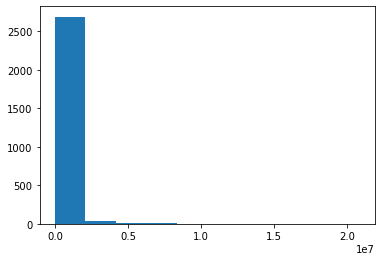

In [20]:
plt.hist(df_normal['likeCount'])

(array([1758.,  186.,  103.,   58.,   61.,   36.,   37.,   32.,   19.,
          20.]),
 array([    0. ,  9994.1, 19988.2, 29982.3, 39976.4, 49970.5, 59964.6,
        69958.7, 79952.8, 89946.9, 99941. ]),
 <BarContainer object of 10 artists>)

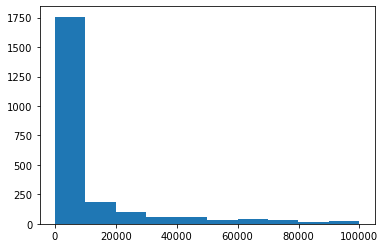

In [21]:
plt.hist(df_normal[df_normal['likeCount']<1e5]['likeCount'])

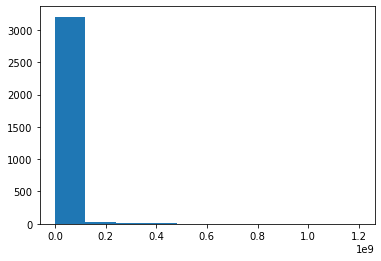

In [22]:
plt.hist(df_normal['viewCount']);

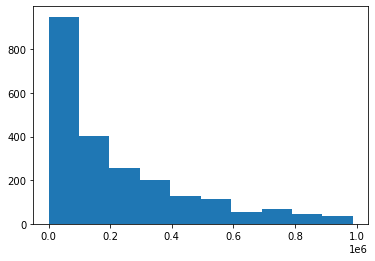

In [23]:
plt.hist(df_normal[df_normal['viewCount']<1e6]['viewCount']);

(array([3.09e+03, 1.09e+02, 6.00e+00, 4.00e+00, 5.00e+00, 1.00e+00,
        4.00e+00, 3.00e+00, 3.00e+00, 2.50e+01]),
 array([    0. ,  8637.9, 17275.8, 25913.7, 34551.6, 43189.5, 51827.4,
        60465.3, 69103.2, 77741.1, 86379. ]),
 <BarContainer object of 10 artists>)

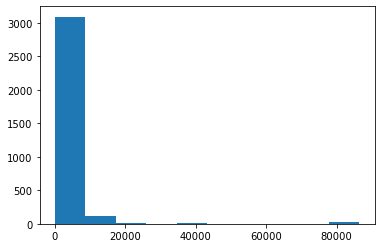

In [24]:
plt.hist(df_normal_preprocessed['durationInt'])

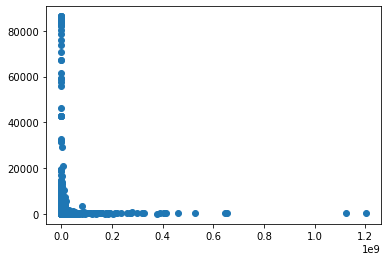

In [25]:
plt.scatter(df_normal_preprocessed['viewCount'], df_normal_preprocessed['durationInt'])

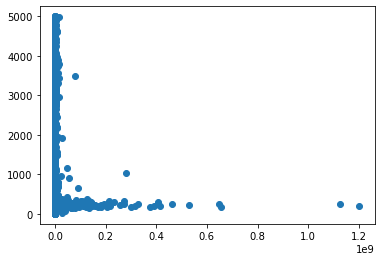

In [26]:
plt.scatter(df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3]['viewCount'], df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3]['durationInt'])

C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/1613510240.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['viewCount'], df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['durationInt'])


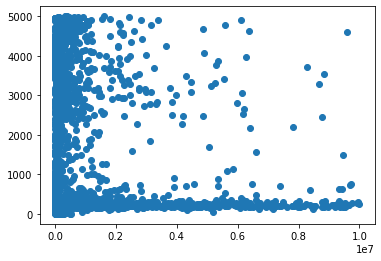

In [30]:

plt.scatter(df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['viewCount'], df_normal_preprocessed[ df_normal_preprocessed['durationInt']<5e3][df_normal_preprocessed['viewCount']<1e7]['durationInt'])

##### Quan hệ giữa các thuộc tính

In [ ]:
corr = df_normal_preprocessed.corr()
print(df_normal_preprocessed.head(5))

In [32]:
df_normal_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3250 entries, 0 to 4960
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3250 non-null   object 
 1   publishAt             3250 non-null   object 
 2   title                 3250 non-null   object 
 3   description           3250 non-null   object 
 4   channelTitle          3250 non-null   object 
 5   tags                  3250 non-null   object 
 6   categoryId            3250 non-null   int64  
 7   defaultAudioLanguage  3250 non-null   object 
 8   duration              3250 non-null   object 
 9   dimension             3250 non-null   object 
 10  definition            3250 non-null   int32  
 11  caption               3250 non-null   int64  
 12  privacyStatus         3250 non-null   int32  
 13  embeddable            3250 non-null   int64  
 14  madeForKids           3250 non-null   int64  
 15  viewCount            

<AxesSubplot:>

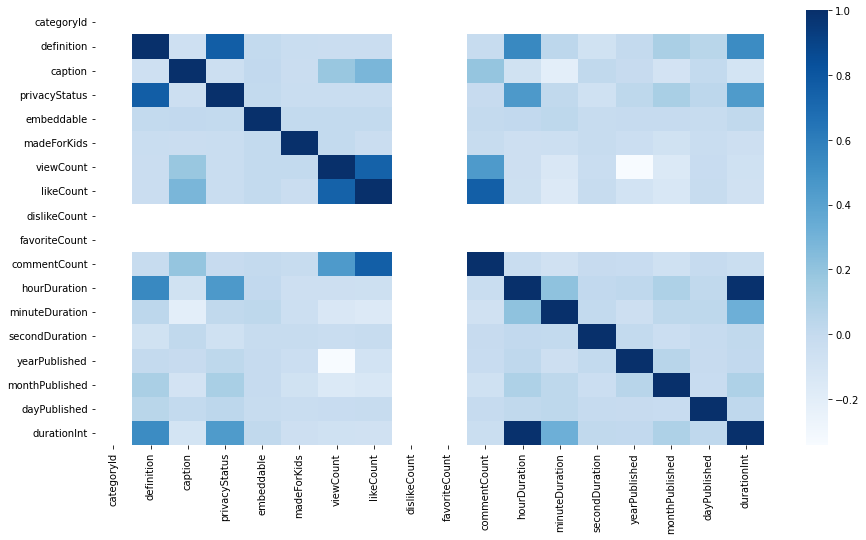

In [33]:
plt.figure(figsize=(15,8))
heatmap_df_normal_preprocess = df_normal_preprocessed[['viewCount','likeCount','dislikeCount','commentCount', 'favoriteCount']]
corr = df_normal_preprocessed.corr()
sns.heatmap(corr, cmap='Blues')

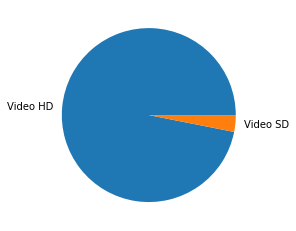

In [27]:
# plt.figure(figsize=(8,16))

# plt.scatter(df_normal_preprocessed['definition'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

hd_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]
sd_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]

y = np.array([hd_videos.shape[0], sd_videos.shape[0]])
mylabel = ['Video HD', 'Video SD']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

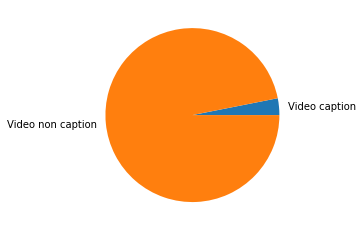

In [67]:
# plt.scatter(df_normal_preprocessed['caption'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Caption')
# plt.xlabel('Caption')
# plt.ylabel('View count')

df_normal['caption'].unique()

caption_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]
non_caption_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]

y = np.array([caption_videos.shape[0], non_caption_videos.shape[0]])
mylabel = ['Video caption', 'Video non caption']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

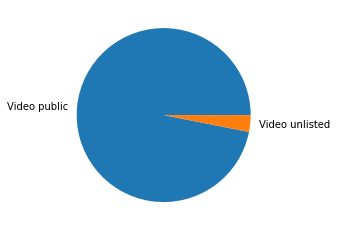

In [28]:
# plt.scatter(df_normal_preprocessed['privacyStatus'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

df_normal['privacyStatus'].unique()

public_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]
unlisted_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]

y = np.array([public_videos.shape[0], unlisted_videos.shape[0]])
mylabel = ['Video public', 'Video unlisted']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

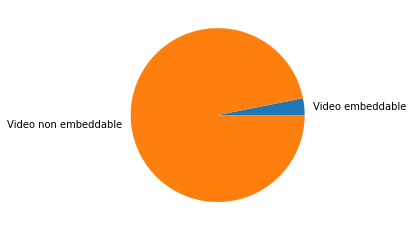

In [31]:
# plt.scatter(df_normal_preprocessed['embeddable'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

# df_normal['embeddable'].unique()

embeddable_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]
non_embeddable_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]

y = np.array([embeddable_videos.shape[0], non_embeddable_videos.shape[0]])
mylabel = ['Video embeddable', 'Video non embeddable']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

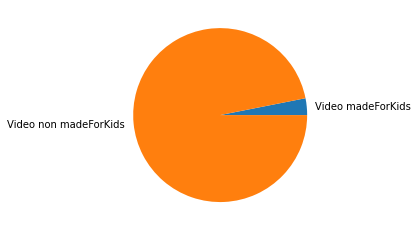

In [29]:
# plt.scatter(df_normal_preprocessed['madeForKids'], df_normal_preprocessed['viewCount'])
# plt.title('View count - Definition')
# plt.xlabel('Definition')
# plt.ylabel('View count')

# df_normal['madeForKids'].unique()
# test = df_normal[df_normal['madeForKids']==False]
madeForKids_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==1]
non_madeForKids_videos = df_normal_preprocessed[df_normal_preprocessed['definition']==0]

y = np.array([madeForKids_videos.shape[0], non_madeForKids_videos.shape[0]])
mylabel = ['Video madeForKids', 'Video non madeForKids']
   
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.pie(y, labels=mylabel)
plt.show()

#### Chuyển text thành vector IF TDF

In [32]:
def convertIfTdf(df, column, stopwords):
    data_train = df[column]
    data_train = removeStopword(data_train, stopwords)

    module_count_vector = TfidfVectorizer(stop_words=stopwords)
    model_rf_preprocess = Pipeline([('vect', module_count_vector),
                        ('tfidf', TfidfTransformer()),
                        ])
    # Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
    # Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
    data_preprocessed = module_count_vector.fit_transform(data_train)

    print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
    print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
    print(f"Xem các từ trong từ điển: {module_count_vector.vocabulary_}")
    print(type(data_preprocessed))
    return data_preprocessed


In [33]:
stopwords = [ 'official', 'mv', 'video', 'music', 'nhạc', 'âm', 'hát', 'tuyển', 'tập', 'bài', 'những', 'ca', ' x ', 'ft','feat']
X = convertIfTdf(df_normal_preprocessed,'title', stopwords)
print(type(X))


Số lượng từ trong từ điển: 4366
Kích thước dữ liệu sau khi xử lý: (3250, 4366)
Xem các từ trong từ điển: {'top': 3522, '15': 32, 'remix': 2890, 'nghe': 2334, 'nhiều': 2410, 'nhất': 2433, 'kẹo': 1796, 'bông': 528, 'gòn': 1327, 'đường': 4156, 'quyền': 2820, 'tình': 3667, 'yêu': 4036, 'em': 1074, 'băng': 532, 'qua': 2802, 'níu': 2523, 'duyên': 1004, 'đang': 4087, 'gây': 1324, 'bão': 513, 'trên': 3575, 'các': 781, 'bxh': 499, 'như': 2428, 'một': 2282, 'người': 2377, 'dưng': 1029, 'lạ': 1977, 'thoáng': 3383, 'họa': 1509, 'ức': 4304, 'dratellingmontee': 975, 'prod': 2781, 'tuanuki': 3621, 'animate': 277, 'sino': 3119, 'thư': 3431, 'giãn': 1256, 'việt': 3812, 'hay': 1368, 'từng': 3730, 'bảng': 542, 'xếp': 3994, 'hạng': 1491, 'khúc': 1709, 'trẻ': 3604, 'tôi': 3675, 'season': 3033, 'nửa': 2561, 'hồn': 1515, 'thương': 3432, 'đau': 4088, 'thanh': 3358, 'lan': 1820, 'liveshow': 1882, 'hải': 1499, 'ngoại': 2354, 'trúc': 3584, 'sinh': 3115, 'entertainment': 1087, '60s': 142, 'búp': 531, 'bê': 518, 

In [82]:
print(X)

  (0, 1004)	0.25047486448785994
  (0, 2523)	0.2988740853258838
  (0, 2802)	0.23780106837311393
  (0, 532)	0.3294105938022687
  (0, 1074)	0.1579569590550027
  (0, 4036)	0.18421293128819713
  (0, 3667)	0.13463311955206134
  (0, 2820)	0.31458735337972
  (0, 4156)	0.21709511989504338
  (0, 1327)	0.2781681368478133
  (0, 528)	0.28731566193398606
  (0, 1796)	0.30870464532419817
  (0, 2433)	0.08386312324291188
  (0, 2410)	0.22219807539399028
  (0, 2334)	0.15191719247539792
  (0, 2890)	0.2613705352185375
  (0, 32)	0.18487047885838115
  (0, 3522)	0.1502255236910078
  (1, 3383)	0.32192048346932345
  (1, 1977)	0.26957386325544436
  (1, 1029)	0.3537642788934553
  (1, 2377)	0.3635595580281702
  (1, 2282)	0.22711259066501735
  (1, 2428)	0.23773006783131254
  (1, 499)	0.1910894711726372
  :	:
  (3245, 285)	0.41470444421339914
  (3245, 19)	0.41470444421339914
  (3245, 475)	0.38045784938682525
  (3245, 2118)	0.38045784938682525
  (3245, 3149)	0.38045784938682525
  (3245, 1565)	0.3119646597336777
  (324

[0.023164089663030876, 0.039909620819172716, 0.04872794349005611, 0.062370705049560334, 0.06660076229787625, 0.0783880510739231, 0.08462073025896108, 0.08917127234450296, 0.09997252259062463, 0.1055457482568419, 0.10817703600515963, 0.11128647193211308, 0.11431530169987784, 0.11774359073633114, 0.12003224807347816, 0.1226529398830654, 0.12501431168704413, 0.12611235384558725, 0.12767810660011328, 0.12931965555226863, 0.12986386144748732, 0.1316012881095006, 0.12970565892113242, 0.12494521797200842, 0.12681051046614045, 0.1280391407118852, 0.1297824862766431, 0.12906196192331224, 0.13424688195126694, 0.132909167457673, 0.1308741483069067, 0.1386039585267501, 0.14133109666300028, 0.13481445072641837, 0.13778872413949306, 0.13773700007003092, 0.1418378690573985, 0.1395149090271229, 0.1431799057711468, 0.14722223026661962, 0.14155944342336033, 0.148037520218912, 0.14938767114825136, 0.14677069291300548, 0.14875747279843535, 0.15229263298505624, 0.14850231056318766, 0.1504522242366402, 0.15

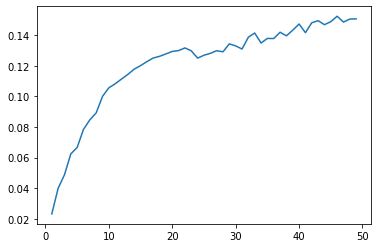

In [95]:
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
s_scores = []
for i in range(1, 50):
    i = i + 1
    spectralClustering = SpectralClustering(n_clusters=i, random_state=0).fit_predict(X)
    s_scores.append(silhouette_score(X, spectralClustering))
print(s_scores)
plt.plot(range(1,50), s_scores)

[0.023164089663030876, 0.039909620819172716, 0.04872794349005611, 0.062370705049560334, 0.06660076229787625, 0.0783880510739231, 0.08462073025896108, 0.08917127234450296, 0.09997252259062463, 0.1055457482568419, 0.10817703600515963, 0.11128647193211308, 0.11431530169987784, 0.11774359073633114, 0.12003224807347816, 0.1226529398830654, 0.12501431168704413, 0.12611235384558725, 0.12767810660011328, 0.12931965555226863, 0.12986386144748732, 0.1316012881095006, 0.12970565892113242, 0.12494521797200842, 0.12681051046614045, 0.1280391407118852, 0.1297824862766431, 0.12906196192331224, 0.13424688195126694, 0.132909167457673, 0.1308741483069067, 0.1386039585267501, 0.14133109666300028, 0.13481445072641837, 0.13778872413949306, 0.13773700007003092, 0.1418378690573985, 0.1395149090271229, 0.1431799057711468, 0.14722223026661962, 0.14155944342336033, 0.148037520218912, 0.14938767114825136, 0.14677069291300548, 0.14875747279843535, 0.15229263298505624, 0.14850231056318766, 0.1504522242366402, 0.15

ValueError: x and y must have same first dimension, but have shapes (49,) and (99,)

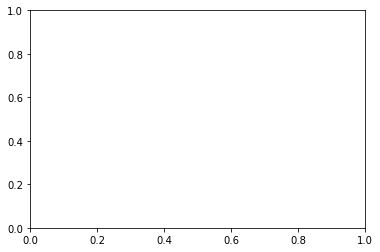

In [96]:
for i in range(50, 100):
    i = i + 1
    spectralClustering = SpectralClustering(n_clusters=i, random_state=0).fit_predict(X)
    s_scores.append(silhouette_score(X, spectralClustering))
print(s_scores)


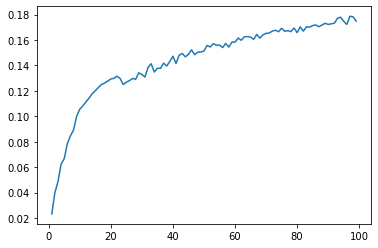

In [97]:
plt.plot(range(1,100), s_scores)

[0.023164089663030876, 0.039909620819172716, 0.04872794349005611, 0.062370705049560334, 0.06660076229787625, 0.0783880510739231, 0.08462073025896108, 0.08917127234450296, 0.09997252259062463, 0.1055457482568419, 0.10817703600515963, 0.11128647193211308, 0.11431530169987784, 0.11774359073633114, 0.12003224807347816, 0.1226529398830654, 0.12501431168704413, 0.12611235384558725, 0.12767810660011328, 0.12931965555226863, 0.12986386144748732, 0.1316012881095006, 0.12970565892113242, 0.12494521797200842, 0.12681051046614045, 0.1280391407118852, 0.1297824862766431, 0.12906196192331224, 0.13424688195126694, 0.132909167457673, 0.1308741483069067, 0.1386039585267501, 0.14133109666300028, 0.13481445072641837, 0.13778872413949306, 0.13773700007003092, 0.1418378690573985, 0.1395149090271229, 0.1431799057711468, 0.14722223026661962, 0.14155944342336033, 0.148037520218912, 0.14938767114825136, 0.14677069291300548, 0.14875747279843535, 0.15229263298505624, 0.14850231056318766, 0.1504522242366402, 0.15

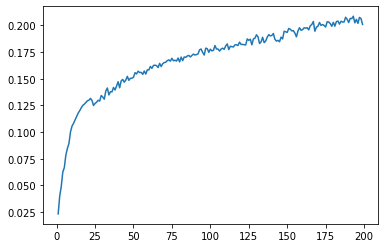

In [98]:
for i in range(100, 200):
    i = i + 1
    spectralClustering = SpectralClustering(n_clusters=i, random_state=0).fit_predict(X)
    s_scores.append(silhouette_score(X, spectralClustering))
print(s_scores)
plt.plot(range(1,200), s_scores)

In [80]:
spectralClustering.affinity_matrix_ 

array([[1.        , 0.15961481, 0.13533528, ..., 0.13533528, 0.13533528,
        0.13533528],
       [0.15961481, 1.        , 0.13533528, ..., 0.13533528, 0.13533528,
        0.13533528],
       [0.13533528, 0.13533528, 1.        , ..., 0.13533528, 0.13533528,
        0.13533528],
       ...,
       [0.13533528, 0.13533528, 0.13533528, ..., 1.        , 0.13533528,
        0.13533528],
       [0.13533528, 0.13533528, 0.13533528, ..., 0.13533528, 1.        ,
        0.13533528],
       [0.13533528, 0.13533528, 0.13533528, ..., 0.13533528, 0.13533528,
        1.        ]])

In [76]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
loss = []
for i in range(50):
    i = i + 1
    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    loss.append(kmeans.inertia_)


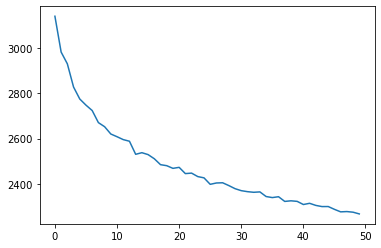

In [75]:
plt.plot(np.arange(0, 50, 1), loss)

In [40]:
clustering = KMeans(n_clusters=10,init='k-means++', random_state=0).fit(X)
clustering.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00209965, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [98]:
label = clustering.labels_
print(label.shape)
for i in label:
    print(i)

(3250,)
5
6
6
6
3
6
6
6
6
6
6
6
8
6
6
6
6
6
6
6
6
6
6
5
6
6
6
6
6
6
6
6
8
6
6
6
6
5
6
6
6
3
6
6
6
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
3
6
6
6
5
8
8
6
6
5
6
6
8
6
6
6
6
8
6
3
6
6
6
8
6
6
6
8
8
3
6
6
3
6
6
6
6
8
6
8
6
6
6
6
6
6
6
6
1
1
1
1
6
1
5
6
1
5
9
5
5
5
7
4
1
5
1
1
1
6
1
6
5
1
2
5
4
1
4
5
4
1
1
1
1
6
1
5
5
9
5
6
7
6
6
1
7
6
6
1
5
7
8
6
6
6
6
2
6
1
5
1
6
6
1
6
1
1
6
1
6
7
6
9
2
1
4
5
6
8
6
6
1
2
8
5
1
6
6
1
6
6
1
1
6
6
6
1
4
8
6
6
8
1
9
8
6
1
1
6
5
6
6
6
5
6
6
7
4
5
6
6
1
2
8
6
6
1
6
1
1
5
5
2
6
7
6
5
6
5
8
8
6
6
2
6
6
6
1
6
6
1
1
8
6
1
6
1
6
6
5
6
5
5
1
1
6
6
6
8
1
6
6
6
6
6
8
6
5
5
6
6
1
6
6
1
6
1
1
6
6
1
6
1
6
6
5
6
6
6
1
5
6
1
8
6
5
6
6
1
6
1
6
8
6
6
8
8
6
6
8
6
6
1
6
8
6
6
6
6
1
1
6
6
1
6
1
6
1
6
1
1
8
6
8
6
6
1
8
8
8
6
8
8
1
8
8
6
6
6
6
8
8
6
6
8
8
8
8
6
6
8
8
6
6
8
5
6
6
6
8
6
6
6
8
8
8
8
6
6
8
8
8
6
6
6
6
6
6
6
6
6
6
6
6
6
0
2
2
0
0
5
0
6
0
0
0
0
6
5
6
0
6
5
0
0
0
0
0
0
5
0
4
0
4
4
0
0
0
4
9
0
6
0
6
0
2
4
0
4
4
4
0
0
4
4
0
0
4
0
4
0
0
9
0
2
4
0
0
5
5
9
9
0
0


In [100]:
spectralClustering = SpectralClustering(n_clusters=20, random_state=0).fit(X)
labelSpectral = spectralClustering.labels_
print(labelSpectral.shape)
for i in labelSpectral:
    print(i)

(3250,)
8
8
8
8
9
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
1
8
8
8
8
8
8
8
8
8
8
8
8
9
8
8
8
8
8
8
8
8
7
8
8
8
8
8
8
8
15
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
15
1
8
8
8
8
8
1
8
0
0
0
0
1
0
8
8
6
2
3
8
2
8
18
11
6
1
6
4
0
1
6
8
8
0
14
8
11
6
11
8
11
6
6
4
4
8
4
8
8
3
0
8
18
8
1
4
18
8
8
6
8
18
8
8
16
8
8
14
8
4
1
6
8
8
4
8
6
4
8
6
8
18
8
3
14
4
11
1
8
15
8
8
4
14
8
8
4
8
8
4
8
8
13
4
8
8
8
8
11
15
8
8
15
4
3
15
8
0
4
8
8
1
8
8
8
8
8
18
11
8
8
8
4
14
15
8
1
0
1
13
13
8
8
14
8
18
8
8
8
8
15
15
8
8
14
8
8
8
4
8
8
13
13
8
8
13
8
0
8
1
8
8
8
8
13
1
8
8
8
15
1
8
8
8
1
8
15
8
1
8
8
8
1
8
8
0
1
13
13
8
8
0
8
13
8
8
8
8
8
8
13
8
8
1
15
8
8
8
8
0
8
13
8
8
8
8
15
15
8
1
15
8
8
13
8
15
8
8
8
8
13
13
1
1
13
1
13
1
13
1
13
13
8
8
15
8
8
13
15
15
15
8
15
8
0
15
8
8
8
1
8
8
15
1
8
15
15
15
15
8
8
15
15
1
8
15
8
8
8
8
8
8
8
8
15
8
15
8
1
1
15
8
15
1
1
1
1
1
1
1
1
1
1
1
1
1
17
14
14
17
8
2
10
1
5
10
19
5
8
8
8
10
8
8
17
17
5
19
17
17


In [109]:
kModel =KMeans(n_clusters=10,init='k-means++', random_state=0).fit_predict(X)
spectralClustering = SpectralClustering(n_clusters=20, random_state=0).fit_predict(X)
print(silhouette_score(X, kModel))
print(silhouette_score(X, spectralClustering))

0.09538920139119363
0.12767810660011328


In [103]:
temp_df_spec = df_normal_preprocessed.assign(label=labelSpectral)
temp_df_spec = temp_df_spec.assign(topics = listTopics)
temp_df_spec.info()

for i in range(len(np.unique(labelSpectral))):
    print(i)
    filter_df_spec = temp_df_spec[labelSpectral==i]
    filter_df_spec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3250 entries, 0 to 4960
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3250 non-null   object 
 1   publishAt             3250 non-null   object 
 2   title                 3250 non-null   object 
 3   description           3250 non-null   object 
 4   channelTitle          3250 non-null   object 
 5   tags                  3250 non-null   object 
 6   categoryId            3250 non-null   int64  
 7   defaultAudioLanguage  3250 non-null   object 
 8   duration              3250 non-null   object 
 9   dimension             3250 non-null   object 
 10  definition            3250 non-null   int32  
 11  caption               3250 non-null   int64  
 12  privacyStatus         3250 non-null   int32  
 13  embeddable            3250 non-null   int64  
 14  madeForKids           3250 non-null   int64  
 15  viewCount            

In [99]:
temp_df = df_normal_preprocessed.assign(label=label)
temp_df = temp_df.assign(topics = listTopics)
temp_df.info()

for i in range(len(np.unique(label))):
    print(i)
    filter_df = temp_df[label==i]
    filter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3250 entries, 0 to 4960
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    3250 non-null   object 
 1   publishAt             3250 non-null   object 
 2   title                 3250 non-null   object 
 3   description           3250 non-null   object 
 4   channelTitle          3250 non-null   object 
 5   tags                  3250 non-null   object 
 6   categoryId            3250 non-null   int64  
 7   defaultAudioLanguage  3250 non-null   object 
 8   duration              3250 non-null   object 
 9   dimension             3250 non-null   object 
 10  definition            3250 non-null   int32  
 11  caption               3250 non-null   int64  
 12  privacyStatus         3250 non-null   int32  
 13  embeddable            3250 non-null   int64  
 14  madeForKids           3250 non-null   int64  
 15  viewCount            

In [105]:
def drawWordCloud(df, column, stopwords):
  for i in range(len(np.unique(label))):
      
      #Extract cleaned text column
      data=df[df['label']==i][column].values
      data = removeStopword(data, stopwords)
      list_of_words=[];
      for sent in data:
        if type(sent)!=str:
          continue
        for word in sent.split():
          list_of_words.append(word)  
      final_text=" ".join(list_of_words)
      wordcloud = WordCloud(collocations=False).generate(final_text)
      plt.figure()
      title="\nCluster : "+str(i+1)+"\n Number of Videos : "+str(len(data))
      plt.title(title)
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()
      print(wordcloud.words_)



In [107]:
def drawWordCloudSpec(df, column, stopwords):
  for i in range(len(np.unique(labelSpectral))):
      
      #Extract cleaned text column
      data=df[df['label']==i][column].values
      data = removeStopword(data, stopwords)
      list_of_words=[];
      for sent in data:
        if type(sent)!=str:
          continue
        for word in sent.split():
          list_of_words.append(word)  
      final_text=" ".join(list_of_words)
      wordcloud = WordCloud(collocations=False).generate(final_text)
      plt.figure()
      title="\nCluster : "+str(i+1)+"\n Number of Videos : "+str(len(data))
      plt.title(title)
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()
      print(wordcloud.words_)

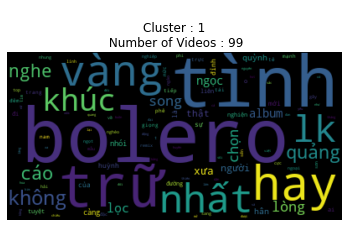

{'bolero': 1.0, 'tình': 1.0, 'trữ': 0.7946428571428571, 'hay': 0.6607142857142857, 'vàng': 0.5982142857142857, 'nhất': 0.5982142857142857, 'lk': 0.5267857142857143, 'khúc': 0.35714285714285715, 'không': 0.32142857142857145, 'quảng': 0.30357142857142855, 'cáo': 0.29464285714285715, 'nghe': 0.2767857142857143, 'song': 0.16071428571428573, 'chọn': 0.16071428571428573, 'lòng': 0.16071428571428573, 'lọc': 0.125, 'album': 0.11607142857142858, 'ngọc': 0.11607142857142858, 'xưa': 0.10714285714285714, 'người': 0.09821428571428571, 'thật': 0.08928571428571429, 'quỳnh': 0.08035714285714286, 'hân': 0.08035714285714286, 'nhói': 0.07142857142857142, 'càng': 0.07142857142857142, 'sự': 0.0625, 'mới': 0.0625, 'huỳnh': 0.0625, 'của': 0.0625, 'đỉnh': 0.0625, 'là': 0.0625, 'đi': 0.05357142857142857, 'ai': 0.05357142857142857, 'tuyệt': 0.05357142857142857, 'o': 0.05357142857142857, 'nghiện': 0.05357142857142857, 'liên': 0.05357142857142857, 'đường': 0.05357142857142857, 'trực': 0.044642857142857144, 'tiếp'

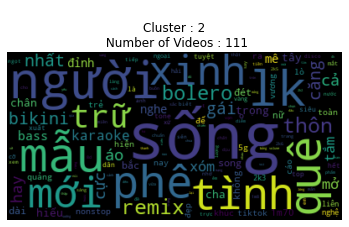

{'sống': 1.0, 'người': 0.5697674418604651, 'lk': 0.5348837209302325, 'mẫu': 0.5, 'phê': 0.4418604651162791, 'quê': 0.4418604651162791, 'tình': 0.4418604651162791, 'mới': 0.4069767441860465, 'xinh': 0.3953488372093023, 'trữ': 0.36046511627906974, 'remix': 0.36046511627906974, 'thôn': 0.3488372093023256, 'bolero': 0.3372093023255814, 'bikini': 0.3372093023255814, 'căng': 0.32558139534883723, 'gái': 0.32558139534883723, 'nhất': 0.313953488372093, 'cực': 0.29069767441860467, 'cả': 0.27906976744186046, 'áo': 0.27906976744186046, 'hay': 0.2558139534883721, 'mở': 0.23255813953488372, 'tắm': 0.23255813953488372, 'xóm': 0.22093023255813954, 'karaoke': 0.20930232558139536, 'bass': 0.18604651162790697, 'mê': 0.1511627906976744, 'đỉnh': 0.1511627906976744, 'nghe': 0.1511627906976744, 'cha': 0.13953488372093023, 'tây': 0.13953488372093023, 'trọng': 0.13953488372093023, 'hiếu': 0.13953488372093023, 'chân': 0.13953488372093023, 'đét': 0.12790697674418605, 'bắc': 0.12790697674418605, 'song': 0.1279069

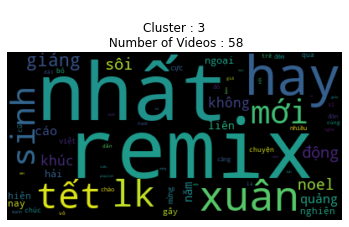

{'remix': 1.0, 'nhất': 0.9629629629629629, 'hay': 0.8888888888888888, 'xuân': 0.8703703703703703, 'tết': 0.6296296296296297, 'lk': 0.6296296296296297, 'sinh': 0.5555555555555556, 'mới': 0.5185185185185185, 'giáng': 0.5185185185185185, 'sôi': 0.4074074074074074, 'động': 0.4074074074074074, 'noel': 0.35185185185185186, 'không': 0.2777777777777778, 'khúc': 0.2777777777777778, 'quảng': 0.25925925925925924, 'cáo': 0.25925925925925924, 'năm': 0.24074074074074073, 'liên': 0.2222222222222222, 'hải': 0.2037037037037037, 'ngoại': 0.2037037037037037, 'hiện': 0.18518518518518517, 'nay': 0.18518518518518517, 'nghiện': 0.18518518518518517, 'gây': 0.16666666666666666, 'việt': 0.14814814814814814, 'mừng': 0.14814814814814814, 'cực': 0.14814814814814814, 'chúc': 0.12962962962962962, 'chuyện': 0.12962962962962962, 'cũ': 0.12962962962962962, 'bỏ': 0.12962962962962962, 'qua': 0.12962962962962962, 'căng': 0.1111111111111111, 'đỏ': 0.1111111111111111, 'chào': 0.1111111111111111, 'đón': 0.1111111111111111, '

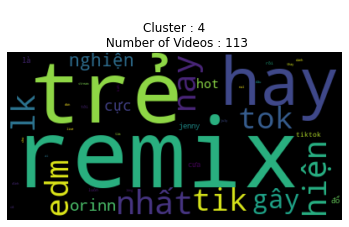

{'remix': 1.0, 'trẻ': 0.852589641434263, 'hay': 0.5976095617529881, 'nhất': 0.4860557768924303, 'hiện': 0.450199203187251, 'nay': 0.450199203187251, 'edm': 0.450199203187251, 'lk': 0.44223107569721115, 'tik': 0.42231075697211157, 'tok': 0.42231075697211157, 'gây': 0.4103585657370518, 'nghiện': 0.4103585657370518, 'orinn': 0.350597609561753, 'cực': 0.29880478087649404, 'hot': 0.18326693227091634, 'jenny': 0.043824701195219126, 'cưa': 0.0398406374501992, 'là': 0.0398406374501992, 'đổ': 0.0398406374501992, 'tiktok': 0.027888446215139442, 'rồi': 0.00796812749003984, 'tới': 0.00796812749003984, 'luôn': 0.00796812749003984, 'nal': 0.00398406374501992, 'cô': 0.00398406374501992, 'đơn': 0.00398406374501992, 'dành': 0.00398406374501992, 'cho': 0.00398406374501992, 'ai': 0.00398406374501992, 'biết': 0.00398406374501992, 'tìm': 0.00398406374501992, 'đâu': 0.00398406374501992, 'july': 0.00398406374501992, 'live': 0.00398406374501992, 'stream': 0.00398406374501992, 'đỉnh': 0.00398406374501992, 'tha

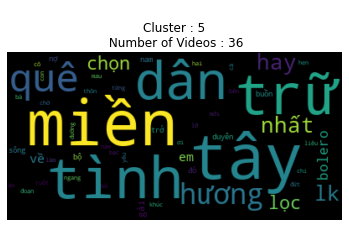

{'miền': 1.0, 'tây': 1.0, 'trữ': 0.810126582278481, 'tình': 0.810126582278481, 'dân': 0.6582278481012658, 'quê': 0.4936708860759494, 'hương': 0.45569620253164556, 'hay': 0.25316455696202533, 'nhất': 0.25316455696202533, 'lk': 0.22784810126582278, 'chọn': 0.17721518987341772, 'lọc': 0.17721518987341772, 'bolero': 0.08860759493670886, 'em': 0.0759493670886076, 'về': 0.0759493670886076, 'gái': 0.0379746835443038, 'nam': 0.02531645569620253, 'bộ': 0.02531645569620253, 'sông': 0.02531645569620253, 'đò': 0.02531645569620253, 'buồn': 0.02531645569620253, 'duyên': 0.02531645569620253, 'nợ': 0.02531645569620253, 'trở': 0.02531645569620253, 'bến': 0.012658227848101266, 'chờ': 0.012658227848101266, 'đứt': 0.012658227848101266, 'từng': 0.012658227848101266, 'đoạn': 0.012658227848101266, 'ruột': 0.012658227848101266, 'ngang': 0.012658227848101266, 'khúc': 0.012658227848101266, 'bà': 0.012658227848101266, 'năm': 0.012658227848101266, 'bỏ': 0.012658227848101266, 'con': 0.012658227848101266, 'lỡ': 0.0

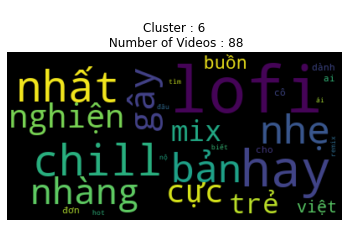

{'lofi': 1.0, 'hay': 0.5877862595419847, 'chill': 0.40458015267175573, 'nhất': 0.40458015267175573, 'bản': 0.33587786259541985, 'nhẹ': 0.33587786259541985, 'nhàng': 0.33587786259541985, 'gây': 0.33587786259541985, 'nghiện': 0.33587786259541985, 'cực': 0.3320610687022901, 'mix': 0.2633587786259542, 'trẻ': 0.25190839694656486, 'buồn': 0.07251908396946564, 'việt': 0.06870229007633588, 'cô': 0.007633587786259542, 'đơn': 0.007633587786259542, 'dành': 0.007633587786259542, 'cho': 0.007633587786259542, 'ai': 0.007633587786259542, 'remix': 0.003816793893129771, 'ái': 0.003816793893129771, 'nộ': 0.003816793893129771, 'hot': 0.003816793893129771, 'biết': 0.003816793893129771, 'tìm': 0.003816793893129771, 'đâu': 0.003816793893129771}


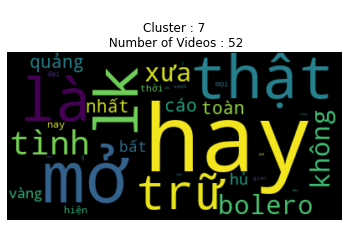

{'hay': 1.0, 'mở': 0.5252525252525253, 'thật': 0.5252525252525253, 'là': 0.5252525252525253, 'lk': 0.5252525252525253, 'trữ': 0.5252525252525253, 'tình': 0.5252525252525253, 'bolero': 0.5252525252525253, 'xưa': 0.5252525252525253, 'không': 0.5252525252525253, 'quảng': 0.5252525252525253, 'cáo': 0.5252525252525253, 'toàn': 0.5252525252525253, 'nhất': 0.5151515151515151, 'bất': 0.37373737373737376, 'hủ': 0.37373737373737376, 'vàng': 0.3434343434343434, 'hiện': 0.13131313131313133, 'nay': 0.13131313131313133, 'thời': 0.10101010101010101, 'mọi': 0.0707070707070707, 'đại': 0.0707070707070707, 'vượt': 0.030303030303030304, 'gian': 0.030303030303030304, 'cho': 0.010101010101010102, 'cả': 0.010101010101010102, 'xóm': 0.010101010101010102, 'cùng': 0.010101010101010102, 'phê': 0.010101010101010102, 'bản': 0.010101010101010102, 'phối': 0.010101010101010102, 'mới': 0.010101010101010102}


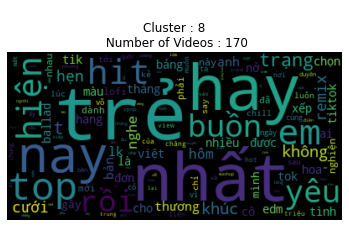

{'trẻ': 1.0, 'nhất': 0.786046511627907, 'hay': 0.6976744186046512, 'nay': 0.4325581395348837, 'top': 0.4, 'em': 0.3395348837209302, 'hit': 0.30697674418604654, 'hiện': 0.3023255813953488, 'buồn': 0.2372093023255814, 'yêu': 0.2372093023255814, 'rồi': 0.22790697674418606, 'trạng': 0.22325581395348837, 't': 0.2186046511627907, 'không': 0.16279069767441862, 'khúc': 0.15813953488372093, 'cưới': 0.14883720930232558, 'hẹn': 0.14418604651162792, 'remix': 0.13953488372093023, 'nghe': 0.13023255813953488, 'hôm': 0.12093023255813953, 'anh': 0.10697674418604651, 'thương': 0.10232558139534884, 'lk': 0.09767441860465116, 'bản': 0.09767441860465116, 'việt': 0.08837209302325581, 'là': 0.08837209302325581, 'được': 0.08372093023255814, 'cô': 0.08372093023255814, 'tháng': 0.08372093023255814, 'hoa': 0.07906976744186046, 'chọn': 0.07906976744186046, 'bảng': 0.07441860465116279, 'xếp': 0.07441860465116279, 'hạng': 0.07441860465116279, 'edm': 0.07441860465116279, 'tình': 0.06976744186046512, 'nở': 0.0697674

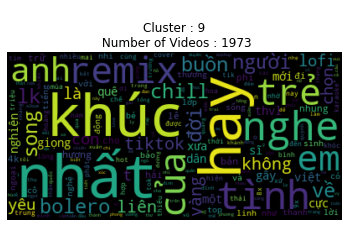

{'nhất': 1.0, 'khúc': 0.9714964370546318, 'hay': 0.9524940617577197, 'nghe': 0.40380047505938244, 'tình': 0.3847980997624703, 'của': 0.33729216152019004, 'trẻ': 0.332541567695962, 'remix': 0.3254156769596199, 'em': 0.31116389548693585, 'anh': 0.2660332541567696, 'người': 0.24703087885985747, 'bolero': 0.23990498812351543, 'song': 0.23040380047505937, 'lk': 0.22802850356294538, 'chill': 0.22327790973871733, 'buồn': 0.22327790973871733, 'đời': 0.22327790973871733, 'về': 0.2161520190023753, 'không': 0.1995249406175772, 'liên': 0.19714964370546317, 'tiktok': 0.19239904988123516, 'vàng': 0.18527315914489312, 't': 0.17339667458432304, 'lofi': 0.17339667458432304, 'chọn': 0.17339667458432304, 'là': 0.171021377672209, 'yêu': 0.16864608076009502, 'con': 0.16864608076009502, 'giọng': 0.16864608076009502, 'xưa': 0.16864608076009502, 'mới': 0.166270783847981, 'quê': 0.15676959619952494, 'việt': 0.14726840855106887, 'gây': 0.1377672209026128, 'cực': 0.1377672209026128, 'thvl': 0.13539192399049882, 

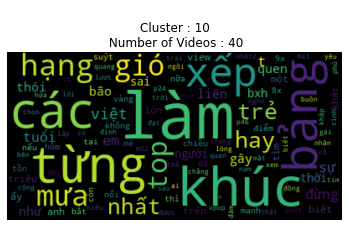

{'làm': 1.0, 'khúc': 0.6666666666666666, 'từng': 0.5757575757575758, 'các': 0.5454545454545454, 'bảng': 0.5303030303030303, 'xếp': 0.5303030303030303, 'hạng': 0.5303030303030303, 'mưa': 0.5151515151515151, 'gió': 0.5, 'top': 0.4696969696969697, 'hay': 0.30303030303030304, 'trẻ': 0.30303030303030304, 'nhất': 0.2878787878787879, 'việt': 0.12121212121212122, 't': 0.10606060606060606, 'sự': 0.10606060606060606, 'đừng': 0.10606060606060606, 'em': 0.10606060606060606, 'tuổi': 0.09090909090909091, 'gây': 0.07575757575757576, 'bão': 0.07575757575757576, 'liên': 0.07575757575757576, 'như': 0.07575757575757576, 'thói': 0.07575757575757576, 'quen': 0.07575757575757576, 'người': 0.06060606060606061, 'sai': 0.06060606060606061, 'thời': 0.06060606060606061, 'bxh': 0.06060606060606061, 'khác': 0.045454545454545456, 'biệt': 0.045454545454545456, 'lớn': 0.045454545454545456, 'trên': 0.045454545454545456, 'ấy': 0.045454545454545456, 'tìm': 0.045454545454545456, 'anh': 0.045454545454545456, 'triệu': 0.04

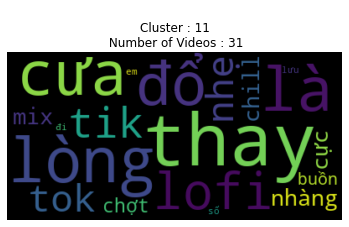

{'thay': 1.0, 'lòng': 1.0, 'cưa': 1.0, 'là': 1.0, 'đổ': 1.0, 'lofi': 1.0, 'tik': 1.0, 'tok': 1.0, 'nhẹ': 1.0, 'nhàng': 1.0, 'cực': 1.0, 'chill': 1.0, 'mix': 1.0, 'chợt': 0.967741935483871, 'buồn': 0.967741935483871, 'lưu': 0.06451612903225806, 'số': 0.06451612903225806, 'em': 0.06451612903225806, 'đi': 0.06451612903225806}


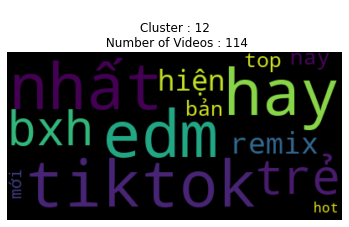

{'edm': 1.0, 'tiktok': 1.0, 'hay': 1.0, 'nhất': 1.0, 'bxh': 0.5, 'trẻ': 0.5, 'remix': 0.5, 'hiện': 0.5, 'nay': 0.5, 'top': 0.5, 'bản': 0.5, 'mới': 0.30701754385964913, 'hot': 0.19298245614035087}


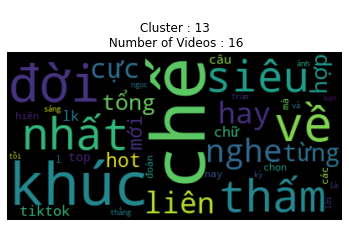

{'chế': 1.0, 'khúc': 0.5853658536585366, 'đời': 0.43902439024390244, 'về': 0.3902439024390244, 'thấm': 0.3170731707317073, 'nhất': 0.3170731707317073, 'siêu': 0.2926829268292683, 'nghe': 0.2682926829268293, 'liên': 0.21951219512195122, 'hay': 0.21951219512195122, 'cực': 0.1951219512195122, 'từng': 0.1951219512195122, 'tổng': 0.17073170731707318, 'hợp': 0.17073170731707318, 'hot': 0.12195121951219512, 'mới': 0.12195121951219512, 'tiktok': 0.0975609756097561, 'chữ': 0.0975609756097561, 'lk': 0.0975609756097561, 'câu': 0.07317073170731707, 'top': 0.07317073170731707, 'mà': 0.04878048780487805, 'các': 0.04878048780487805, 'chọn': 0.04878048780487805, 'đoàn': 0.04878048780487805, 'l': 0.04878048780487805, 'hiện': 0.04878048780487805, 'nay': 0.04878048780487805, 'ngọc': 0.024390243902439025, 'ánh': 0.024390243902439025, 'sáng': 0.024390243902439025, 'lời': 0.024390243902439025, 'thằng': 0.024390243902439025, 'bạn': 0.024390243902439025, 'tồi': 0.024390243902439025, 'kỳ': 0.024390243902439025

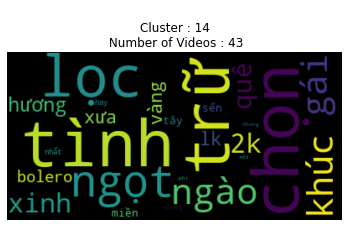

{'trữ': 1.0, 'tình': 1.0, 'chọn': 1.0, 'lọc': 1.0, 'ngọt': 1.0, 'ngào': 1.0, 'khúc': 0.9767441860465116, 'gái': 0.9767441860465116, 'xinh': 0.9767441860465116, '2k': 0.9767441860465116, 'quê': 0.9302325581395349, 'hương': 0.9302325581395349, 'lk': 0.813953488372093, 'vàng': 0.7906976744186046, 'xưa': 0.7906976744186046, 'bolero': 0.6046511627906976, 'sến': 0.20930232558139536, 'miền': 0.20930232558139536, 'tây': 0.20930232558139536, 'hay': 0.06976744186046512, 'nhất': 0.06976744186046512, 'thương': 0.023255813953488372, 'xót': 0.023255813953488372, 'phi': 0.023255813953488372, 'nhung': 0.023255813953488372}


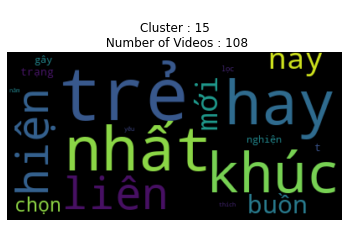

{'trẻ': 1.0, 'nhất': 0.6802507836990596, 'hay': 0.6739811912225705, 'khúc': 0.54858934169279, 'liên': 0.3385579937304075, 'hiện': 0.3385579937304075, 'nay': 0.3385579937304075, 'mới': 0.3322884012539185, 'buồn': 0.219435736677116, 'chọn': 0.11598746081504702, 't': 0.01567398119122257, 'trạng': 0.01567398119122257, 'gây': 0.012539184952978056, 'nghiện': 0.012539184952978056, 'lọc': 0.006269592476489028, 'yêu': 0.003134796238244514, 'thích': 0.003134796238244514, 'năm': 0.003134796238244514}


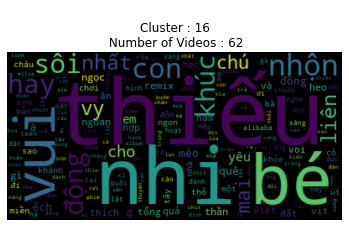

{'thiếu': 1.0, 'nhi': 1.0, 'bé': 0.7448979591836735, 'vui': 0.46938775510204084, 'nhộn': 0.4489795918367347, 'con': 0.3979591836734694, 'động': 0.3673469387755102, 'sôi': 0.35714285714285715, 'khúc': 0.35714285714285715, 'hay': 0.336734693877551, 'nhất': 0.3163265306122449, 'liên': 0.30612244897959184, 'mai': 0.2755102040816326, 'vy': 0.2653061224489796, 'chú': 0.21428571428571427, 'cho': 0.15306122448979592, 'yêu': 0.08163265306122448, 'em': 0.07142857142857142, 'đồng': 0.061224489795918366, 'quê': 0.061224489795918366, 'ếch': 0.061224489795918366, 'mèo': 0.061224489795918366, 'ngoan': 0.05102040816326531, 'thần': 0.05102040816326531, 'remix': 0.05102040816326531, 'gì': 0.05102040816326531, 'ngọc': 0.05102040816326531, 'heo': 0.05102040816326531, 'việt': 0.04081632653061224, 'nam': 0.04081632653061224, 'voi': 0.04081632653061224, 'thích': 0.04081632653061224, 'quả': 0.04081632653061224, 'tổng': 0.04081632653061224, 'hợp': 0.04081632653061224, 'đất': 0.04081632653061224, 'và': 0.040816

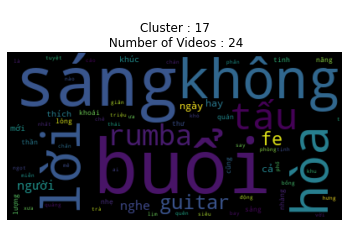

{'buổi': 1.0, 'sáng': 1.0, 'không': 0.6304347826086957, 'lời': 0.5869565217391305, 'hòa': 0.5217391304347826, 'tấu': 0.5217391304347826, 'rumba': 0.5217391304347826, 'guitar': 0.5, 'fe': 0.43478260869565216, 'người': 0.15217391304347827, 'nghe': 0.15217391304347827, 'cả': 0.08695652173913043, 'ngày': 0.08695652173913043, 'hay': 0.08695652173913043, 'thích': 0.06521739130434782, 'khúc': 0.06521739130434782, 'mới': 0.06521739130434782, 'lòng': 0.043478260869565216, 'quán': 0.043478260869565216, 'nhẹ': 0.043478260869565216, 'nhàng': 0.043478260869565216, 'năng': 0.043478260869565216, 'lượng': 0.043478260869565216, 'tinh': 0.043478260869565216, 'thần': 0.043478260869565216, 'thư': 0.043478260869565216, 'sảng': 0.043478260869565216, 'khoái': 0.043478260869565216, 'cũng': 0.043478260869565216, 'siêu': 0.021739130434782608, 'chấn': 0.021739130434782608, 'động': 0.021739130434782608, 'khu': 0.021739130434782608, 'phố': 0.021739130434782608, 'khó': 0.021739130434782608, 'quên': 0.02173913043478

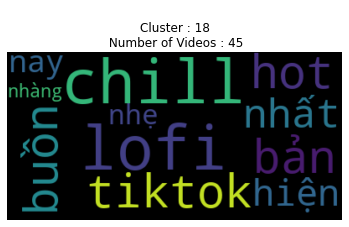

{'chill': 1.0, 'lofi': 0.9888888888888889, 'tiktok': 0.5, 'bản': 0.5, 'buồn': 0.5, 'hot': 0.5, 'nhất': 0.5, 'hiện': 0.5, 'nay': 0.5, 'nhẹ': 0.4888888888888889, 'nhàng': 0.4888888888888889}


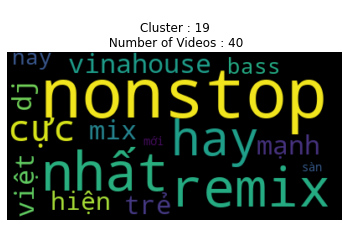

{'nonstop': 1.0, 'remix': 0.55, 'nhất': 0.55, 'hay': 0.5, 'cực': 0.5, 'mạnh': 0.5, 'việt': 0.5, 'mix': 0.5, 'vinahouse': 0.5, 'dj': 0.4875, 'trẻ': 0.45, 'hiện': 0.45, 'nay': 0.45, 'bass': 0.45, 'mới': 0.05, 'sàn': 0.05}


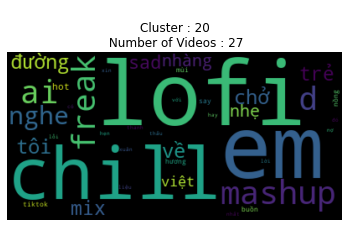

{'lofi': 1.0, 'em': 0.9814814814814815, 'chill': 0.7592592592592593, 'mashup': 0.5185185185185185, 'ai': 0.5, 'freak': 0.5, 'd': 0.5, 'nghe': 0.48148148148148145, 'đường': 0.46296296296296297, 'tôi': 0.46296296296296297, 'chở': 0.46296296296296297, 'về': 0.46296296296296297, 'mix': 0.42592592592592593, 'trẻ': 0.42592592592592593, 'sad': 0.4074074074074074, 'nhẹ': 0.35185185185185186, 'nhàng': 0.35185185185185186, 'việt': 0.24074074074074073, 'hot': 0.07407407407407407, 'buồn': 0.037037037037037035, 'mùi': 0.037037037037037035, 'hương': 0.037037037037037035, 'nồng': 0.037037037037037035, 'say': 0.037037037037037035, 'tiktok': 0.037037037037037035, 'hay': 0.018518518518518517, 'nhất': 0.018518518518518517, 'nợ': 0.018518518518518517, 'đó': 0.018518518518518517, 'lời': 0.018518518518518517, 'xin': 0.018518518518518517, 'lỗi': 0.018518518518518517, 'liệu': 0.018518518518518517, 'thấu': 0.018518518518518517, 'có': 0.018518518518518517, 'hẹn': 0.018518518518518517, 'với': 0.01851851851851851

In [108]:
drawWordCloudSpec(temp_df_spec,'title', stopwords)

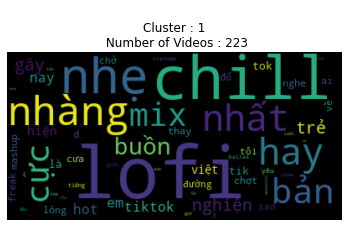

{'lofi': 1.0, 'chill': 0.6504065040650406, 'nhẹ': 0.4065040650406504, 'nhàng': 0.4065040650406504, 'hay': 0.34146341463414637, 'nhất': 0.3394308943089431, 'bản': 0.29878048780487804, 'cực': 0.2804878048780488, 'mix': 0.25609756097560976, 'buồn': 0.21544715447154472, 'nghiện': 0.19715447154471544, 'gây': 0.1951219512195122, 'trẻ': 0.18699186991869918, 'em': 0.12601626016260162, 'tiktok': 0.11178861788617886, 'hot': 0.10569105691056911, 'nay': 0.1016260162601626, 'hiện': 0.09349593495934959, 'việt': 0.08536585365853659, 'là': 0.07113821138211382, 'tik': 0.07113821138211382, 'tok': 0.07113821138211382, 'thay': 0.06300813008130081, 'lòng': 0.06300813008130081, 'cưa': 0.06300813008130081, 'đổ': 0.06300813008130081, 'mashup': 0.06300813008130081, 'chợt': 0.06097560975609756, 'ai': 0.05894308943089431, 'freak': 0.05894308943089431, 'd': 0.05894308943089431, 'nghe': 0.054878048780487805, 'đường': 0.04878048780487805, 'tôi': 0.04878048780487805, 'chở': 0.04878048780487805, 'về': 0.0487804878048

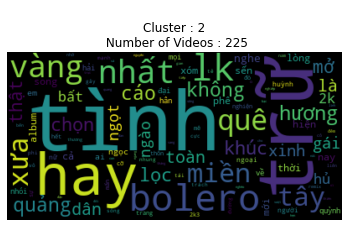

{'tình': 1.0, 'trữ': 0.9222614840989399, 'hay': 0.6784452296819788, 'bolero': 0.6431095406360424, 'lk': 0.6219081272084805, 'nhất': 0.4628975265017668, 'vàng': 0.43109540636042404, 'quê': 0.36395759717314485, 'xưa': 0.3392226148409894, 'miền': 0.3250883392226148, 'tây': 0.3215547703180212, 'hương': 0.31802120141342755, 'không': 0.29328621908127206, 'quảng': 0.29328621908127206, 'cáo': 0.28975265017667845, 'khúc': 0.254416961130742, 'chọn': 0.254416961130742, 'lọc': 0.24734982332155478, 'mở': 0.2226148409893993, 'thật': 0.2226148409893993, 'là': 0.2049469964664311, 'toàn': 0.2049469964664311, 'dân': 0.2049469964664311, 'gái': 0.18021201413427562, 'xinh': 0.17667844522968199, 'ngọt': 0.16607773851590105, 'ngào': 0.16607773851590105, '2k': 0.14840989399293286, 'bất': 0.14487632508833923, 'hủ': 0.14487632508833923, 'nghe': 0.0706713780918728, 'sến': 0.05653710247349823, 'album': 0.053003533568904596, 'hiện': 0.04946996466431095, 'nay': 0.04946996466431095, 'phê': 0.045936395759717315, 'son

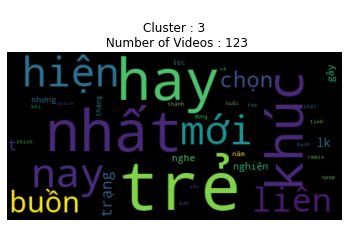

{'trẻ': 1.0, 'hay': 0.6713091922005571, 'nhất': 0.6685236768802229, 'khúc': 0.5153203342618384, 'hiện': 0.32590529247910865, 'nay': 0.32590529247910865, 'mới': 0.3147632311977716, 'liên': 0.31197771587743733, 'buồn': 0.23119777158774374, 'chọn': 0.116991643454039, 't': 0.04178272980501393, 'trạng': 0.04178272980501393, 'lk': 0.022284122562674095, 'gây': 0.016713091922005572, 'nghiện': 0.016713091922005572, 'nghe': 0.013927576601671309, 'nhưng': 0.011142061281337047, 'lọc': 0.005571030640668524, 'năm': 0.005571030640668524, 'tháng': 0.005571030640668524, 'quách': 0.002785515320334262, 'thành': 0.002785515320334262, 'danh': 0.002785515320334262, 'yêu': 0.002785515320334262, 'thích': 0.002785515320334262, 'vpop': 0.002785515320334262, 'top': 0.002785515320334262, 'tuổi': 0.002785515320334262, 'remix': 0.002785515320334262, 'đừng': 0.002785515320334262, 'khi': 0.002785515320334262, 'thất': 0.002785515320334262, 'tình': 0.002785515320334262, 'và': 0.002785515320334262, 'bxh': 0.002785515320

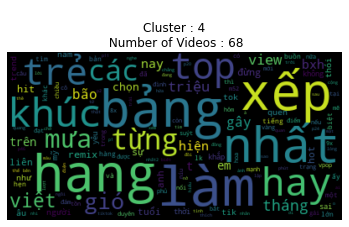

{'làm': 1.0, 'bảng': 0.8636363636363636, 'xếp': 0.8636363636363636, 'hạng': 0.8636363636363636, 'nhất': 0.7727272727272727, 'khúc': 0.7575757575757576, 'hay': 0.7272727272727273, 'top': 0.696969696969697, 'trẻ': 0.6818181818181818, 'từng': 0.6515151515151515, 'các': 0.6363636363636364, 'mưa': 0.5151515151515151, 'gió': 0.5, 'việt': 0.36363636363636365, 'tháng': 0.19696969696969696, 'triệu': 0.18181818181818182, 'view': 0.18181818181818182, 'gây': 0.16666666666666666, 'bão': 0.16666666666666666, 'bxh': 0.15151515151515152, 'hiện': 0.15151515151515152, 'nay': 0.15151515151515152, 't': 0.13636363636363635, 'trên': 0.13636363636363635, 'em': 0.13636363636363635, 'chọn': 0.12121212121212122, 'sự': 0.10606060606060606, 'đừng': 0.10606060606060606, 'remix': 0.10606060606060606, 'hit': 0.10606060606060606, 'tuổi': 0.09090909090909091, 'liên': 0.09090909090909091, 'anh': 0.09090909090909091, 'hot': 0.09090909090909091, 'nam': 0.07575757575757576, 'người': 0.07575757575757576, 'như': 0.075757575

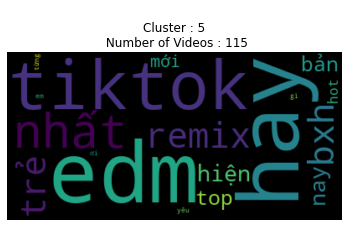

{'hay': 1.0, 'edm': 0.9956521739130435, 'tiktok': 0.9956521739130435, 'nhất': 0.9956521739130435, 'remix': 0.5043478260869565, 'bxh': 0.5, 'trẻ': 0.5, 'hiện': 0.5, 'nay': 0.5, 'top': 0.4956521739130435, 'bản': 0.4956521739130435, 'mới': 0.30434782608695654, 'hot': 0.19130434782608696, 'em': 0.004347826086956522, 'gì': 0.004347826086956522, 'ơi': 0.004347826086956522, 'từng': 0.004347826086956522, 'yêu': 0.004347826086956522}


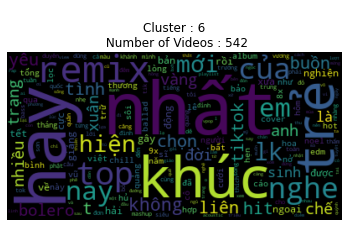

{'nhất': 1.0, 'hay': 0.8957528957528957, 'khúc': 0.5598455598455598, 'trẻ': 0.5135135135135135, 'remix': 0.2953667953667954, 'top': 0.21042471042471042, 'nghe': 0.1969111969111969, 'của': 0.1969111969111969, 'nay': 0.1891891891891892, 'em': 0.17953667953667954, 'lk': 0.16023166023166024, 'mới': 0.15057915057915058, 'hiện': 0.14671814671814673, 'không': 0.14092664092664092, 'hit': 0.13320463320463322, 'liên': 0.1274131274131274, 'buồn': 0.1274131274131274, 'chọn': 0.1274131274131274, 'yêu': 0.12548262548262548, 't': 0.12355212355212356, 'tình': 0.11969111969111969, 'tiktok': 0.11969111969111969, 'bolero': 0.10617760617760617, 'trạng': 0.10424710424710425, 'anh': 0.10231660231660232, 'vàng': 0.09845559845559845, 'nhiều': 0.09652509652509653, 'chế': 0.0945945945945946, 'đời': 0.0945945945945946, 'xuân': 0.0888030888030888, 'là': 0.08108108108108109, 'sinh': 0.08108108108108109, 'nghiện': 0.07915057915057915, 'được': 0.07915057915057915, 'hải': 0.07528957528957529, 'ngoại': 0.0752895752895

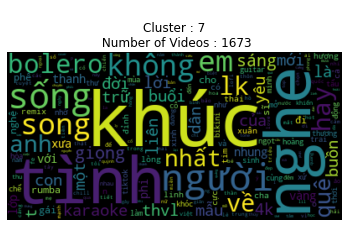

{'khúc': 1.0, 'tình': 0.7040816326530612, 'nghe': 0.6938775510204082, 'người': 0.6887755102040817, 'sống': 0.6020408163265306, 'không': 0.5153061224489796, 'song': 0.5051020408163265, 'em': 0.49489795918367346, 'bolero': 0.45918367346938777, 'lk': 0.4336734693877551, 'hay': 0.42346938775510207, 'về': 0.40816326530612246, 'anh': 0.37755102040816324, 'nhất': 0.37244897959183676, 'quê': 0.35714285714285715, 'giọng': 0.3520408163265306, 'sáng': 0.3469387755102041, 'đời': 0.32653061224489793, 'buồn': 0.3112244897959184, 'là': 0.3010204081632653, 'lời': 0.2857142857142857, 'thvl': 0.2857142857142857, 'con': 0.2755102040816326, 'karaoke': 0.27040816326530615, 'mẫu': 0.2653061224489796, 'buổi': 0.2653061224489796, 'mới': 0.2602040816326531, 'của': 0.2602040816326531, 'trữ': 0.2602040816326531, 'yêu': 0.25, 'liên': 0.25, 't': 0.24489795918367346, 'dân': 0.23979591836734693, '4k': 0.23979591836734693, 'một': 0.23469387755102042, 'nhung': 0.23469387755102042, 'thanh': 0.22448979591836735, 'với': 

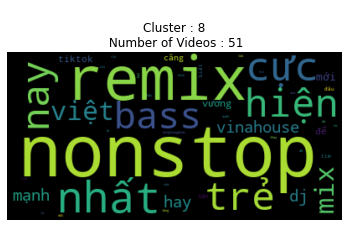

{'nonstop': 1.0, 'remix': 0.6847826086956522, 'nhất': 0.5869565217391305, 'cực': 0.532608695652174, 'trẻ': 0.4891304347826087, 'hiện': 0.4891304347826087, 'nay': 0.4891304347826087, 'bass': 0.4891304347826087, 'việt': 0.44565217391304346, 'mix': 0.44565217391304346, 'vinahouse': 0.44565217391304346, 'hay': 0.43478260869565216, 'mạnh': 0.43478260869565216, 'dj': 0.43478260869565216, 'mới': 0.15217391304347827, 'vương': 0.11956521739130435, 'đế': 0.10869565217391304, 'tiktok': 0.10869565217391304, 'căng': 0.09782608695652174, 'sàn': 0.043478260869565216, 'biết': 0.03260869565217391, 'tìm': 0.03260869565217391, 'đâu': 0.03260869565217391, 'dunghoangpham': 0.010869565217391304, 'một': 0.010869565217391304, 'bậc': 0.010869565217391304, 'quân': 0.010869565217391304, 'áo': 0.010869565217391304, 'cũ': 0.010869565217391304, 'tình': 0.010869565217391304, 'em': 0.010869565217391304, 'thay': 0.010869565217391304, 'lòng': 0.010869565217391304, 'hot': 0.010869565217391304, 'tik': 0.01086956521739130

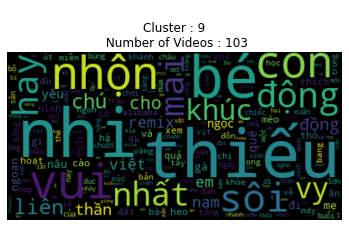

{'nhi': 1.0, 'thiếu': 0.9922480620155039, 'bé': 0.7364341085271318, 'vui': 0.4728682170542636, 'nhộn': 0.4418604651162791, 'con': 0.40310077519379844, 'sôi': 0.32558139534883723, 'động': 0.32558139534883723, 'hay': 0.3178294573643411, 'mai': 0.3023255813953488, 'nhất': 0.29457364341085274, 'khúc': 0.29457364341085274, 'vy': 0.2868217054263566, 'liên': 0.24031007751937986, 'chú': 0.2248062015503876, 'cho': 0.16279069767441862, 'đồng': 0.13953488372093023, 'thần': 0.12403100775193798, 'em': 0.10852713178294573, 'việt': 0.10852713178294573, 'nam': 0.10852713178294573, 'remix': 0.10852713178294573, 'quê': 0.06976744186046512, 'yêu': 0.06976744186046512, 'ếch': 0.06201550387596899, 'ngọc': 0.06201550387596899, 'ngoan': 0.05426356589147287, 'gà': 0.05426356589147287, 'nâu': 0.05426356589147287, 'mẹ': 0.05426356589147287, 'đi': 0.05426356589147287, 'heo': 0.046511627906976744, 'gì': 0.046511627906976744, 'và': 0.046511627906976744, 'cào': 0.046511627906976744, 'thỏ': 0.046511627906976744, 'mè

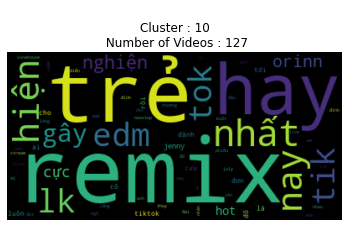

{'remix': 1.0, 'trẻ': 0.8369565217391305, 'hay': 0.5942028985507246, 'nhất': 0.4927536231884058, 'hiện': 0.4528985507246377, 'nay': 0.4528985507246377, 'edm': 0.4492753623188406, 'lk': 0.4384057971014493, 'tik': 0.4311594202898551, 'tok': 0.4311594202898551, 'gây': 0.42028985507246375, 'nghiện': 0.42028985507246375, 'orinn': 0.33695652173913043, 'cực': 0.27898550724637683, 'hot': 0.16666666666666666, 'jenny': 0.043478260869565216, 'cưa': 0.036231884057971016, 'là': 0.036231884057971016, 'đổ': 0.036231884057971016, 'rồi': 0.036231884057971016, 'tới': 0.036231884057971016, 'luôn': 0.03260869565217391, 'tiktok': 0.028985507246376812, 'cô': 0.025362318840579712, 'đơn': 0.025362318840579712, 'dành': 0.025362318840579712, 'cho': 0.025362318840579712, 'ai': 0.025362318840579712, 'mỹ': 0.0036231884057971015, 'nhân': 0.0036231884057971015, 'đinh': 0.0036231884057971015, 'đại': 0.0036231884057971015, 'vũ': 0.0036231884057971015, 'căng': 0.0036231884057971015, 'nal': 0.0036231884057971015, 'biết'

In [101]:
drawWordCloud(temp_df,'title', stopwords)

0


C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']


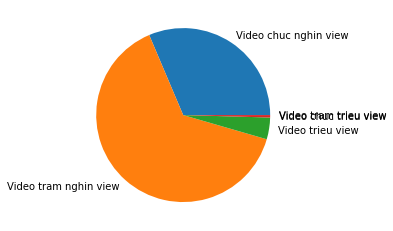

1


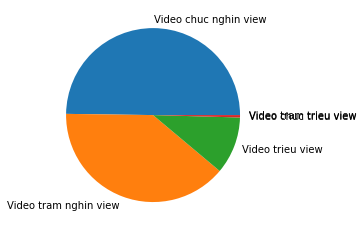

2


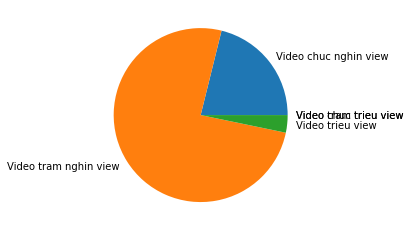

3


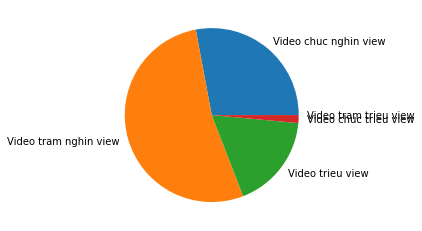

4


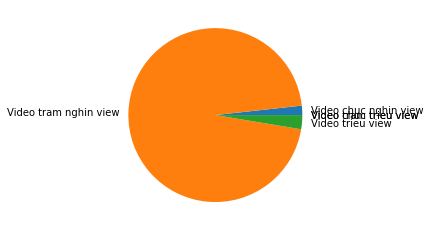

5


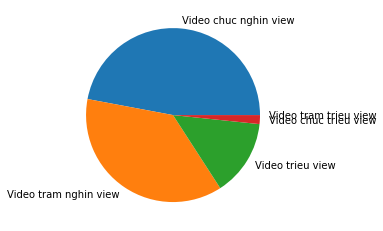

6


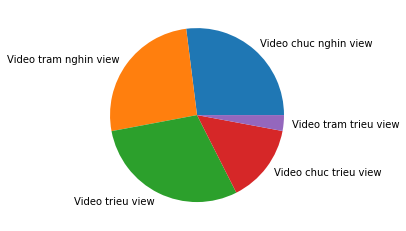

7


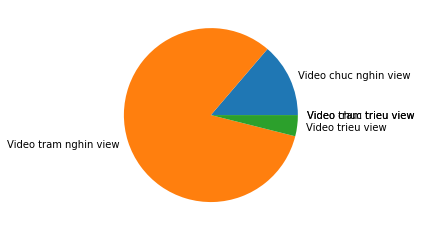

8


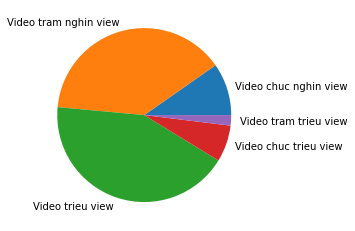

9


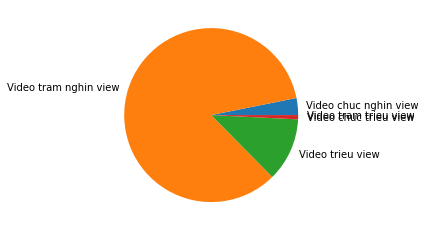

In [80]:
for i in range(len(np.unique(label))):
    print(i)
    pieCharViewCounts(temp_df[temp_df['label']==i])

In [61]:
clustered_df = temp_df.groupby(['label']).sum()

In [67]:
clustered_df[['viewCount', 'likeCount', 'durationInt']]

,viewCount,likeCount,durationInt
label,,,
0,89230736,515148.0,724423
1,118550098,2384239.0,2447635
2,41940541,232354.0,746225
3,53205338,155784.0,461525
4,51183052,447746.0,583905
5,429444263,2714349.0,3205259
6,23534411417,475847929.0,3167148
7,19900713,154324.0,223874
8,782986636,1703104.0,148220


In [81]:
abnormal_cluster = temp_df[temp_df['label']==6]
# abnormal_cluster = abnormal_cluster[abnormal_cluster['label']==2]

In [82]:
stopwords = [ 'official', 'mv', 'video', 'music', 'nhạc', 'âm', 'hát', 'tuyển', 'tập', 'bài', 'những', 'ca', ' x ', 'ft','feat']
X_abnormal = convertIfTdf(abnormal_cluster,'title', stopwords)
print(type(X_abnormal))
kmeans = KMeans(n_clusters=5,init='k-means++', random_state=0).fit(X_abnormal)
kmeans.cluster_centers_

label = kmeans.labels_

print(label.shape)
for i in label:
    print(i)
abnormal_cluster = abnormal_cluster.assign(label = label)


Số lượng từ trong từ điển: 3994
Kích thước dữ liệu sau khi xử lý: (1673, 3994)
Xem các từ trong từ điển: {'top': 3220, 'đang': 3732, 'gây': 1185, 'bão': 414, 'trên': 3269, 'các': 660, 'bxh': 400, 'như': 2219, 'một': 2088, 'người': 2177, 'dưng': 900, 'lạ': 1803, 'thoáng': 3090, 'qua': 2542, 'họa': 1359, 'ức': 3932, 'dratellingmontee': 849, 'prod': 2521, 'tuanuki': 3311, 'animate': 187, 'sino': 2840, 'thư': 3133, 'giãn': 1119, 'tôi': 3362, 'season': 2756, 'nửa': 2319, 'hồn': 1365, 'thương': 3134, 'đau': 3733, 'thanh': 3066, 'lan': 1654, 'liveshow': 1716, 'hải': 1349, 'ngoại': 2156, 'trúc': 3277, 'sinh': 2836, 'entertainment': 952, '60s': 86, 'búp': 431, 'bê': 419, 'trò': 3273, 'chơi': 546, 'con': 606, 'mực': 2094, 'squid': 2911, 'game': 1076, 'nhảy': 2222, 'cực': 718, 'sung': 2954, 'cùng': 678, 'trai': 3232, 'đẹp': 3814, 'rise': 2648, 'above': 122, 'tripledmai': 3247, 'mr': 2017, 'vịt': 3546, 'yomost': 3680, 'vfl': 3464, 'winter': 3604, '2021': 45, 'theme': 3072, 'song': 2881, 'vũ': 352

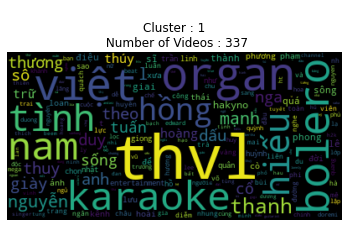

{'thvl': 1.0, 'organ': 0.4888888888888889, 'việt': 0.4444444444444444, 'bolero': 0.4222222222222222, 'karaoke': 0.35555555555555557, 'nam': 0.35555555555555557, 'tình': 0.3111111111111111, 'hiếu': 0.28888888888888886, 'hồng': 0.2222222222222222, 'thanh': 0.2222222222222222, 'nguyễn': 0.2, 'mạnh': 0.2, 'anh': 0.17777777777777778, 'thuy': 0.17777777777777778, 'nga': 0.17777777777777778, 'l': 0.17777777777777778, 'thương': 0.17777777777777778, 'theo': 0.17777777777777778, 'dấu': 0.17777777777777778, 'giày': 0.17777777777777778, 'sô': 0.17777777777777778, 'duy': 0.17777777777777778, 'sống': 0.15555555555555556, 'tuấn': 0.15555555555555556, 'cổ': 0.15555555555555556, 'hoàng': 0.15555555555555556, 'trữ': 0.15555555555555556, 'thúy': 0.15555555555555556, 'hakyno': 0.15555555555555556, 'sĩ': 0.13333333333333333, 'giai': 0.13333333333333333, 'điệu': 0.13333333333333333, 'sông': 0.13333333333333333, 'phong': 0.13333333333333333, 'quá': 0.13333333333333333, 'lê': 0.13333333333333333, 'thành': 0.1

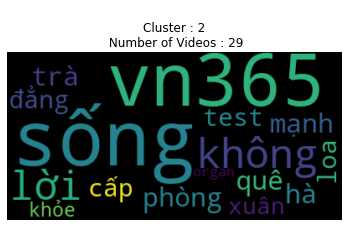

{'sống': 1.0, 'vn365': 0.9565217391304348, 'không': 0.13043478260869565, 'lời': 0.13043478260869565, 'phòng': 0.043478260869565216, 'trà': 0.043478260869565216, 'quê': 0.043478260869565216, 'mạnh': 0.043478260869565216, 'hà': 0.043478260869565216, 'đẳng': 0.043478260869565216, 'cấp': 0.043478260869565216, 'test': 0.043478260869565216, 'loa': 0.043478260869565216, 'xuân': 0.043478260869565216, 'khỏe': 0.043478260869565216, 'organ': 0.043478260869565216}


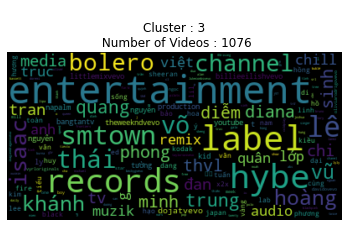

{'entertainment': 1.0, 'label': 0.7692307692307693, 'hybe': 0.7435897435897436, 'records': 0.717948717948718, 'lê': 0.5384615384615384, 'smtown': 0.48717948717948717, 'thái': 0.4358974358974359, 'võ': 0.41025641025641024, 'channel': 0.38461538461538464, 'bolero': 0.38461538461538464, 'isaac': 0.358974358974359, 'khánh': 0.3076923076923077, 'hoàng': 0.3076923076923077, 'vũ': 0.2564102564102564, 'trung': 0.20512820512820512, 'quang': 0.20512820512820512, 'sinh': 0.1794871794871795, 'diễm': 0.1794871794871795, 'minh': 0.1794871794871795, 'thvl': 0.1794871794871795, 'phong': 0.1794871794871795, 'diana': 0.1794871794871795, 'tv': 0.15384615384615385, 'chi': 0.15384615384615385, 'tran': 0.15384615384615385, 'đan': 0.15384615384615385, 'media': 0.15384615384615385, 'truc': 0.1282051282051282, 'chill': 0.1282051282051282, 'anh': 0.1282051282051282, 'g': 0.1282051282051282, 'muzik': 0.1282051282051282, 'lớp': 0.1282051282051282, 'audio': 0.1282051282051282, 'việt': 0.1282051282051282, 'remix': 

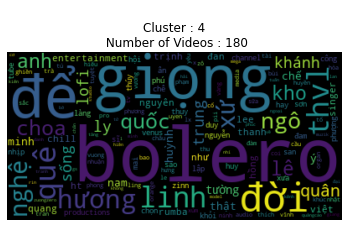

{'bolero': 1.0, 'giọng': 0.9310344827586207, 'để': 0.896551724137931, 'đời': 0.896551724137931, 'quê': 0.4827586206896552, 'thvl': 0.4482758620689655, 'linh': 0.41379310344827586, 'hương': 0.3448275862068966, 'xứ': 0.3103448275862069, 'nghệ': 0.3103448275862069, 'ngô': 0.27586206896551724, 'choa': 0.2413793103448276, 'quốc': 0.2413793103448276, 'lê': 0.20689655172413793, 'anh': 0.20689655172413793, 'kho': 0.20689655172413793, 'quân': 0.20689655172413793, 'khánh': 0.1724137931034483, 'trung': 0.1724137931034483, 'sống': 0.1724137931034483, 'lofi': 0.1724137931034483, 'ly': 0.1724137931034483, 'tường': 0.1724137931034483, 'nam': 0.13793103448275862, 'minh': 0.13793103448275862, 'ý': 0.13793103448275862, 'huỳnh': 0.13793103448275862, 'thật': 0.13793103448275862, 'chế': 0.13793103448275862, 'việt': 0.10344827586206896, 'đan': 0.10344827586206896, 'nguyên': 0.10344827586206896, 'hồng': 0.10344827586206896, 'entertainment': 0.10344827586206896, 'như': 0.10344827586206896, 'singer': 0.1034482

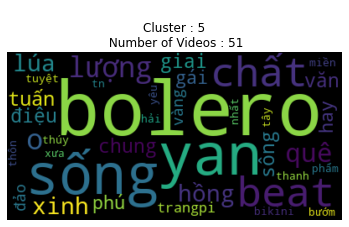

{'bolero': 1.0, 'yan': 0.56, 'sống': 0.52, 'beat': 0.24, 'chất': 0.24, 'lượng': 0.24, 'o': 0.24, 'quê': 0.2, 'hồng': 0.16, 'lúa': 0.16, 'xinh': 0.16, 'tuấn': 0.12, 'chung': 0.12, 'giai': 0.12, 'điệu': 0.12, 'sông': 0.12, 'văn': 0.12, 'phú': 0.12, 'gái': 0.12, 'hay': 0.12, 'đảo': 0.08, 'vàng': 0.08, 'trangpi': 0.08, 'bikini': 0.04, 'yêu': 0.04, 'miền': 0.04, 'tây': 0.04, 'tn': 0.04, 'thanh': 0.04, 'hải': 0.04, 'thôn': 0.04, 'nhất': 0.04, 'thúy': 0.04, 'xưa': 0.04, 'tuyệt': 0.04, 'phẩm': 0.04, 'bướm': 0.04}


In [90]:
for i in range(len(np.unique(label))):
    
    #Extract cleaned text column
    data=abnormal_cluster[abnormal_cluster['label']==i]['channelTitle'].values
    data = removeStopword(data, stopwords)
    list_of_words=[];
    for sent in data:
      if type(sent)!=str:
        continue
      for word in sent.split():
        list_of_words.append(word)  
    final_text=" ".join(list_of_words)
    wordcloud = WordCloud(collocations=False).generate(final_text)
    plt.figure()
    title="\nCluster : "+str(i+1)+"\n Number of Videos : "+str(len(data))
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    print(wordcloud.words_)

0


C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
C:\Users\Admin\AppData\Local\Temp/ipykernel_23172/4254363901.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']


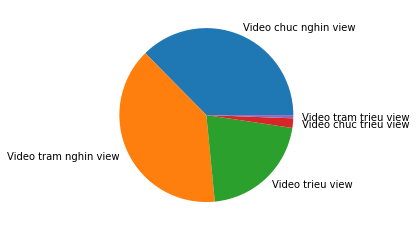

1


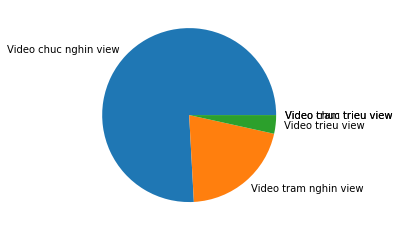

2


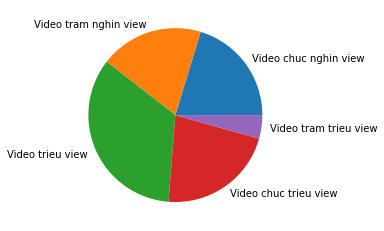

3


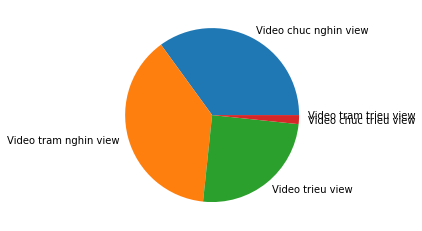

4


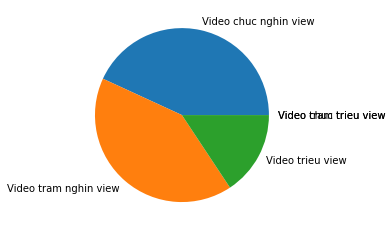

In [84]:
for i in range(len(np.unique(label))):
    print(i)
    pieCharViewCounts(abnormal_cluster[abnormal_cluster['label']==i])

In [87]:
clustered_02_abnormal = abnormal_cluster[abnormal_cluster['label']!=2].sum()
clustered_02_abnormal[['viewCount', 'likeCount', 'durationInt']]

viewCount      994396138
likeCount      7257261.0
durationInt      2442637
dtype: object

In [88]:
clustered_01_abnormal = abnormal_cluster[abnormal_cluster['label']==2].sum()
clustered_01_abnormal[['viewCount', 'likeCount', 'durationInt']]

viewCount      22540015279
likeCount      468590668.0
durationInt         724511
dtype: object

In [ ]:
for item in abnormal_cluster[abnormal_cluster['label']==0]['title']:
    print(item)

Họa Ức - DraTelling x MontEe (Prod. Tuanuki - Animate. SiNo)
Âm Nhạc & Tôi Season 2 - NỬA HỒN THƯƠNG ĐAU | THANH LAN | Liveshow Hải Ngoại Trúc Sinh Entertainment
60S ÂM NHẠC - Búp Bê Trò Chơi Con Mực Squid Game Nhảy Cực Sung cùng Trai Đẹp
[Official MV] RISE ABOVE | TripleD x Mai Âm Nhạc x Mr.Vịt | Yomost VFL Winter 2021 Theme Song
Âm Nhạc & Tôi - NHẠC VŨ TRƯỜNG | Loan Châu, Mỹ Vân | Liveshow Hải Ngoại | Trúc Sinh Entertainment
Ý NIỆM - COLDZY - MAI ÂM NHẠC (LYRICS) RAP VIỆT MÙA 2 TẬP 7 - VÒNG ĐỐI ĐẦU
Âm Nhạc & Tôi, Season 2 | NỖI NIỀM | NHƯ MAI | Live Show Hải Ngoại | Trúc Sinh Entertainment
Âm Nhạc & Tôi - Happy Father’s Day 2021 - "Nhớ Đến Lời Cha” | Trúc Sinh Entertainment
TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm Nhạc | Người Lạ Thoáng Qua, Hẹn Kiếp Sau
Câu chuyện âm nhạc #1 II Cá Heo với âm nhạc II thedien
khi nữ nhạc công phêu cùng âm nhạc và cái kết
KARIK GÂY TRANH CÃI - 2CAN, MAI ÂM NHẠC BỊ LOẠI - SEACHAINS, XÁM TRÌNH DIỄN ĐẲNG CẤP
Âm Nhạc & Tôi, Season 2 | CÔ BÉ DỖI HỜN, 

In [ ]:
print(wordcloud.words_)

{'hồng': 1.0, 'hybe': 0.875, 'labels': 0.875, 'giai': 0.75, 'điệu': 0.75, 'sông': 0.75, 'remix': 0.5, 'sống': 0.25, 'lee': 0.25, 'bangtantv': 0.25, 'vàng': 0.25, 'trữ': 0.25, 'tình': 0.25, 'hoa': 0.25, 'dại': 0.25, 'muzik': 0.25, 'petersounds': 0.125, 'orinn': 0.125, 'thích': 0.125, 'nghe': 0.125, 'huy': 0.125, 'thuỳ': 0.125, 'dung': 0.125, 'bolero': 0.125, 'thái': 0.125, 'quỳnh': 0.125, 'dollypartonvevo': 0.125, "spinnin'": 0.125, 'records': 0.125, 'yang': 0.125, 'tvr': 0.125, 'eltonjohnvevo': 0.125, 'chrisbrownvevo': 0.125, 'alikiba': 0.125, 'mọt': 0.125, 'edm': 0.125, 'mrshin': 0.125, 'chill': 0.125, 'hq': 0.125, 'hậu': 0.125, 'bé': 0.125, "fin'd": 0.125, 'quê': 0.125, 'mình': 0.125, 'tilo': 0.125, 'amp': 0.125, 'theory': 0.125, 'gavin': 0.125, 'magnus': 0.125, 'littlemixvevo': 0.125}
